In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

# Results Analysis
* ...

In [261]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'
VERSION = 'v6/'

In [224]:
def load_plot(page, plot_y_org=True, test=False, VERSION=VERSION):
    if test:
        VERSION = VERSION[:-1]+'t/'
    forecast = pd.read_feather(PROPHET_PATH+VERSION+str(page)+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [29]:
mediandf = pd.read_feather('../data/median_for_60_and_30.f') 

In [30]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
mediandf.info()
mediandf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 11 columns):
page_index           145063 non-null int64
Page                 145063 non-null object
FINAL_median_pred    145063 non-null int64
median_pred_60       145063 non-null int64
median_pred_30       145063 non-null int64
smape_60_to_0        144151 non-null float64
smape_30_to_0        144113 non-null float64
smape_60_to_30       144137 non-null float64
nans_start_to_60     145063 non-null int64
nans_60_to_30        145063 non-null int64
nans_30_to_0         145063 non-null int64
dtypes: float64(3), int64(7), object(1)
memory usage: 12.2+ MB


page_index                                               Page  \
0           0            2NE1_zh.wikipedia.org_all-access_spider   
1           1             2PM_zh.wikipedia.org_all-access_spider   
2           2              3C_zh.wikipedia.org_all-access_spider   
3           3         4minute_zh.wikipedia.org_all-access_spider   
4           4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   

   FINAL_median_pred  median_pred_60  median_pred_30  smape_60_to_0  \
0                 22              24              22      32.278432   
1                 19              24              18      42.847863   
2                  3               3               3      64.305367   
3                 14              15              14      32.250349   
4                 16              14              12      48.547274   

   smape_30_to_0  smape_60_to_30  nans_start_to_60  nans_60_to_30  \
0      33.460075       31.784579                 0              0   
1      38.381387       47.778097                 0              0   
2      66.482751       62.127983                 0              0   
3      34.090675       31.105196                 0              0   
4      63.728757       42.661346               291              0   

   nans_30_to_0  
0             0  
1             0  
2             0  
3             0  
4             0

In [26]:
v6 = pd.read_feather(PROPHET_PATH+RESULTS_PATH+'v6df.f'); 
v6.page_index = v6.page_index.astype(int)
v6 = v6.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(v6.shape)
print(v6.info())
print(v6.v6_val.mean())
v6.head()

(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v6_train      0 non-null float64
v6_val        144196 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.8531845693


page_index  v6_train      v6_val
0           0       NaN   31.961856
1           1       NaN   61.550763
2           2       NaN  162.870370
3           3       NaN   74.371935
4           4       NaN  132.702086

In [27]:
v6t = pd.read_feather(PROPHET_PATH+RESULTS_PATH+'v6tdf.f')
v6t.page_index = v6t.page_index.astype(int)
v6t = v6t.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(v6t.shape)
print(v6t.info())
print(v6t.v6t_val.mean())
v6t.head()

(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v6t_train     0 non-null float64
v6t_val       144113 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
91.9486794124


page_index  v6t_train     v6t_val
0           0        NaN   33.687425
1           1        NaN   79.017942
2           2        NaN  118.306120
3           3        NaN   47.967008
4           4        NaN   99.351753

In [31]:
df = v6.drop('v6_train', axis=1)

In [32]:
df.head()

page_index      v6_val
0           0   31.961856
1           1   61.550763
2           2  162.870370
3           3   74.371935
4           4  132.702086

In [34]:
df = df.merge(v6t.iloc[:,[0,2]], on='page_index')
df = df.merge(mediandf, on='page_index')

In [35]:
df.head()

page_index      v6_val     v6t_val  \
0           0   31.961856   33.687425   
1           1   61.550763   79.017942   
2           2  162.870370  118.306120   
3           3   74.371935   47.967008   
4           4  132.702086   99.351753   

                                                Page  FINAL_median_pred  \
0            2NE1_zh.wikipedia.org_all-access_spider                 22   
1             2PM_zh.wikipedia.org_all-access_spider                 19   
2              3C_zh.wikipedia.org_all-access_spider                  3   
3         4minute_zh.wikipedia.org_all-access_spider                 14   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...                 16   

   median_pred_60  median_pred_30  smape_60_to_0  smape_30_to_0  \
0              24              22      32.278432      33.460075   
1              24              18      42.847863      38.381387   
2               3               3      64.305367      66.482751   
3              15              14      32.250349      34.090675   
4              14              12      48.547274      63.728757   

   smape_60_to_30  nans_start_to_60  nans_60_to_30  nans_30_to_0  
0       31.784579                 0              0             0  
1       47.778097                 0              0             0  
2       62.127983                 0              0             0  
3       31.105196                 0              0             0  
4       42.661346               291              0             0

In [41]:
df2 = df[['page_index']]; df2.head()

page_index
0           0
1           1
2           2
3           3
4           4

In [101]:
df2['nans_60_to_30'] = df.nans_60_to_30
df2['nans_30_to_0'] = df.nans_30_to_0

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [206]:
df2['median_pred_60'] = mediandf.median_pred_60
df2['median_pred_30'] = mediandf.median_pred_30

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
df2['val_gain'] = df.smape_60_to_30 - df.v6_val; df2.head()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


page_index    val_gain
0           0   -0.177277
1           1  -13.772666
2           2 -100.742387
3           3  -43.266739
4           4  -90.040740

In [242]:
df2['smape_30_to_0'] = df.smape_30_to_0
df2['smape_60_to_30'] = df.smape_60_to_30
df2['v6t_val'] = df.v6t_val; df2.head()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

page_index    val_gain  smape_30_to_0     v6t_val  test_gain  \
0           0   -0.177277      33.460075   33.687425  -0.227350   
1           1  -13.772666      38.381387   79.017942 -40.636555   
2           2 -100.742387      66.482751  118.306120 -51.823369   
3           3  -43.266739      34.090675   47.967008 -13.876332   
4           4  -90.040740      63.728757   99.351753 -35.622996   

   nans_60_to_30  nans_30_to_0  median_pred_60  median_pred_30      v6_val  \
0              0             0              24              22   31.961856   
1              0             0              24              18   61.550763   
2              0             0               3               3  162.870370   
3              0             0              15              14   74.371935   
4              0             0              14              12  132.702086   

   smape_60_to_30  
0       31.784579  
1       47.778097  
2       62.127983  
3       31.105196  
4       42.661346

In [46]:
df2[df2.val_gain > 0].shape

(18894, 4)

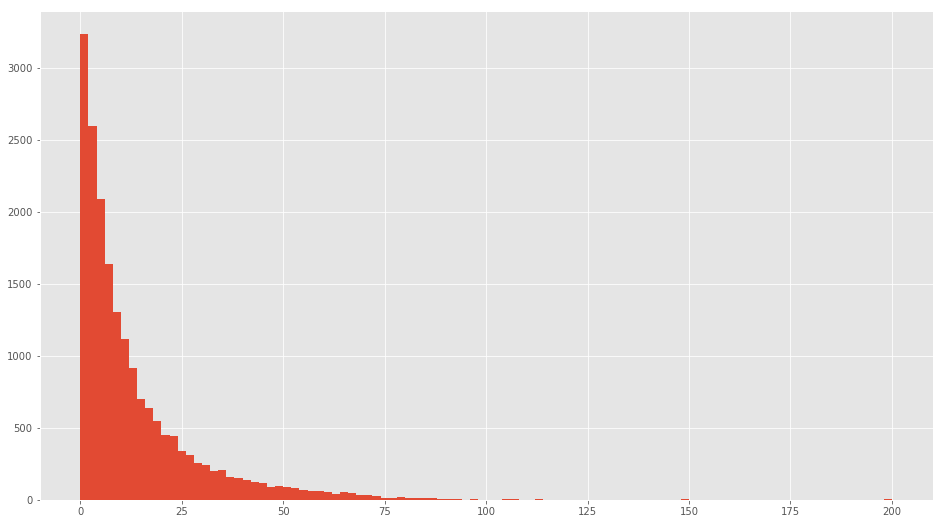

In [47]:
df2[df2.val_gain > 0].val_gain.hist(bins=100)

In [48]:
df2[df2.val_gain > 0].v6t_val.mean()

50.045499913109431

In [81]:
def test_smape_for_val_gain_threshold(threshold):
    return(df2[df2.val_gain > threshold].v6t_val.sum() + df2[df2.val_gain <= threshold].smape_30_to_0.sum())/df2.shape[0]

In [82]:
df2.smape_30_to_0.mean()

37.916231179407006

In [83]:
test_smape_for_val_gain_threshold(0)

38.793764886646997

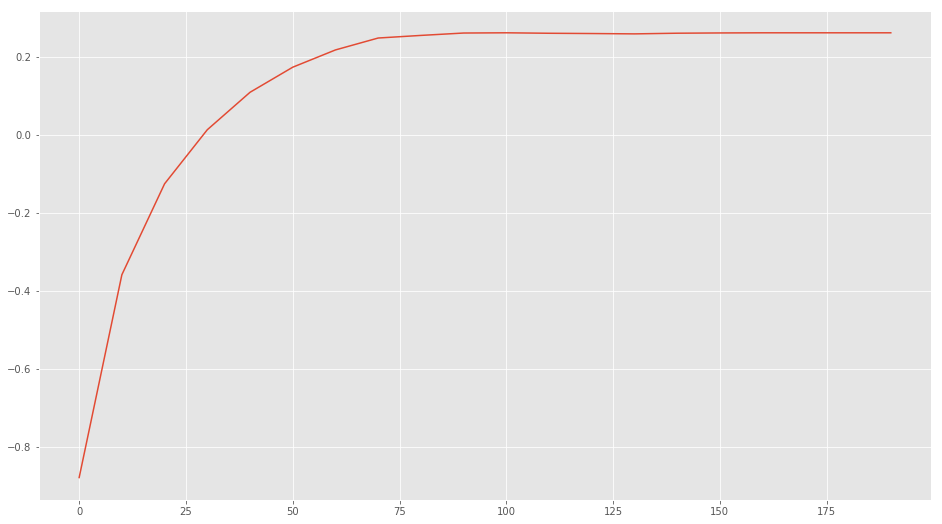

In [98]:
r = range(0,200,10)
plt.plot([i for i in r],[df2.smape_30_to_0.mean() - test_smape_for_val_gain_threshold(i)  for i in r])

In [102]:
df2[df2.val_gain > 150]

page_index   val_gain  smape_30_to_0    v6t_val  test_gain  \
22889       22889  152.03252            0.0  53.333333 -53.333333   
23326       23326  200.00000            0.0   0.000000   0.000000   
78015       78015  200.00000            0.0  22.222222 -22.222222   
78992       78992  200.00000            0.0   0.000000   0.000000   

       nans_60_to_30  nans_30_to_0  
22889             18            15  
23326             28            22  
78015             27            21  
78992             28            23

In [95]:
zzz = zip([i for i in r],[test_smape_for_val_gain_threshold(i)-df2.smape_30_to_0.mean() for i in r])

In [96]:
[i for i in zzz]

[(0, 0.87753370723999069),
 (10, 0.35816736002671945),
 (20, 0.12525351121004036),
 (30, -0.013132620852040588),
 (40, -0.1089952764070361),
 (50, -0.17324787594673552),
 (60, -0.21746306666716464),
 (70, -0.24796330697814284),
 (80, -0.25463123391275388),
 (90, -0.26074532328077282),
 (100, -0.26133033376723347),
 (110, -0.26013712253615751),
 (120, -0.25945145894367272),
 (130, -0.25857063421615578),
 (140, -0.26027517531444033),
 (150, -0.26095464773842991),
 (160, -0.26132230409005075),
 (170, -0.26132230409005075),
 (180, -0.26132230409005075),
 (190, -0.26132230409005075)]

In [74]:
df2['test_gain'] = df2.smape_30_to_0 - df2.v6t_val

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
df2[['val_gain','test_gain']].corr()

val_gain  test_gain
val_gain   1.000000   0.716666
test_gain  0.716666   1.000000

In [80]:
df2[(df2.val_gain >0) & (df2.test_gain >0)].val_gain.mean()

13.276382451999373

In [136]:
def test_smape_for_val_gain_UL_threshold(upper_threshold, lower_threshold):
    v6t_sum = df2[((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].v6t_val.sum()
    v6t_count = df2[((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].v6t_val.count()
    smape_30_0_sum = df2[~((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].smape_30_to_0.sum()
    smape_30_0_count = df2[~((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].smape_30_to_0.count()
    return (v6t_sum + smape_30_0_sum) / (v6t_count + smape_30_0_count)

In [137]:
BASE_SMAPE = df2.smape_30_to_0.mean()

In [138]:
r = range(-200,200,10)
hm = pd.DataFrame([[BASE_SMAPE - test_smape_for_val_gain_UL_threshold(i,j) for i in r] for j in r])

In [131]:
[[(i,j) for i in r] for j in r]

[[(-200, -200),
  (-190, -200),
  (-180, -200),
  (-170, -200),
  (-160, -200),
  (-150, -200),
  (-140, -200),
  (-130, -200),
  (-120, -200),
  (-110, -200),
  (-100, -200),
  (-90, -200),
  (-80, -200),
  (-70, -200),
  (-60, -200),
  (-50, -200),
  (-40, -200),
  (-30, -200),
  (-20, -200),
  (-10, -200),
  (0, -200),
  (10, -200),
  (20, -200),
  (30, -200),
  (40, -200),
  (50, -200),
  (60, -200),
  (70, -200),
  (80, -200),
  (90, -200),
  (100, -200),
  (110, -200),
  (120, -200),
  (130, -200),
  (140, -200),
  (150, -200),
  (160, -200),
  (170, -200),
  (180, -200),
  (190, -200)],
 [(-200, -190),
  (-190, -190),
  (-180, -190),
  (-170, -190),
  (-160, -190),
  (-150, -190),
  (-140, -190),
  (-130, -190),
  (-120, -190),
  (-110, -190),
  (-100, -190),
  (-90, -190),
  (-80, -190),
  (-70, -190),
  (-60, -190),
  (-50, -190),
  (-40, -190),
  (-30, -190),
  (-20, -190),
  (-10, -190),
  (0, -190),
  (10, -190),
  (20, -190),
  (30, -190),
  (40, -190),
  (50, -190),
  (60

In [139]:
import seaborn as sns

In [140]:
hm[hm > -0.1]

0    1    2    3    4    5    6    7    8    9  ...         30        31  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
1   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
2   NaN  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
3   NaN  NaN  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
4   NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
5   NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
6   NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0 ...   0.000000  0.000000   
7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0 ...   0.000000  0.000000   
8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0 ...   0.000000  0.000000   
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0 ...   0.000000  0.000000   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
12  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
13  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
14  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
15  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
16  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
17  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
18  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
20  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
22  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
23  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
24  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
27  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
28  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000000  0.000000   
31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.001201  0.000000   
32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.001891  0.000690   
33  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.002778  0.001577   
34  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.001062 -0.000139   
35  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.001062 -0.000139   
36  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000008 -0.001193   
37  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000008 -0.001193   
38  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000008 -0.001193   
39  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   0.000008 -0.001193   

          32        33            34       35   36   37   38   39  
0   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
1   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
2   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
3   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
4   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
5   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
6   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
7   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
8   0.000000  0.000000  0.000000e+00  0.00000  0.0  0.0  0.0  0.0  
9  

In [141]:
hm.idxmax()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29    33
30    33
31    33
32    33
33     0
34     0
35     0
36     0
37     0
38     0
39     0
dtype: int64

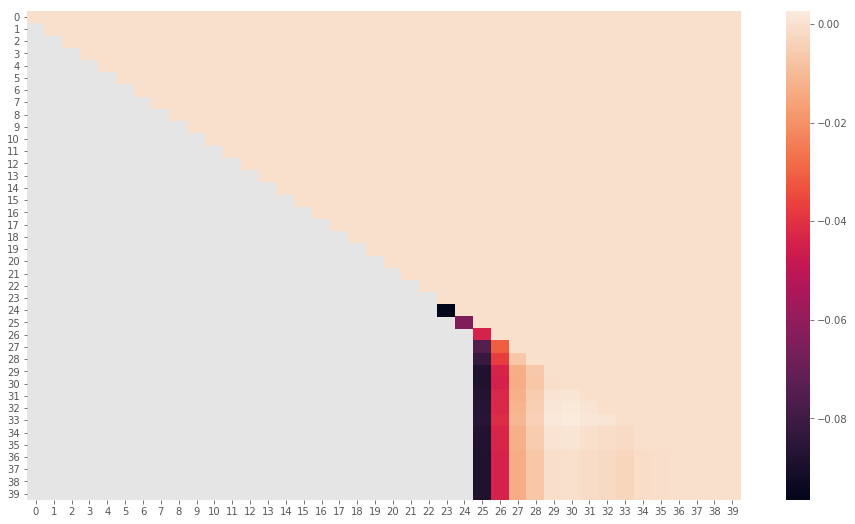

In [144]:
sns.heatmap(hm[hm > -0.1])

In [148]:
hm.max().max()

0.0027778916265788212

In [164]:
def test_smape_for_val_gain_UL_threshold(threshs):
    upper_threshold = threshs[0]
    lower_threshold = threshs[1]
    v6t_sum = df2[((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].v6t_val.sum()
    v6t_count = df2[((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].v6t_val.count()
    smape_30_0_sum = df2[~((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].smape_30_to_0.sum()
    smape_30_0_count = df2[~((df2.val_gain > upper_threshold) & (df2.val_gain < lower_threshold))].smape_30_to_0.count()
    return ((v6t_sum + smape_30_0_sum) / (v6t_count + smape_30_0_count)) - BASE_SMAPE

In [165]:
from scipy.optimize import brute

In [168]:
b = brute(test_smape_for_val_gain_UL_threshold,[(100,150),(100,150)],full_output = True)

In [167]:
a

(array([ 104.21052632,  133.15789474]),
 -0.0028695644943397269,
 array([[[-200.        , -200.        , -200.        , -200.        ,
          -200.        , -200.        , -200.        , -200.        ,
          -200.        , -200.        , -200.        , -200.        ,
          -200.        , -200.        , -200.        , -200.        ,
          -200.        , -200.        , -200.        , -200.        ],
         [-178.94736842, -178.94736842, -178.94736842, -178.94736842,
          -178.94736842, -178.94736842, -178.94736842, -178.94736842,
          -178.94736842, -178.94736842, -178.94736842, -178.94736842,
          -178.94736842, -178.94736842, -178.94736842, -178.94736842,
          -178.94736842, -178.94736842, -178.94736842, -178.94736842],
         [-157.89473684, -157.89473684, -157.89473684, -157.89473684,
          -157.89473684, -157.89473684, -157.89473684, -157.89473684,
          -157.89473684, -157.89473684, -157.89473684, -157.89473684,
          -157.89473684

In [169]:
b

(array([ 103.28947368,  129.93421053]),
 -0.0028695644943397269,
 array([[[ 100.        ,  100.        ,  100.        ,  100.        ,
           100.        ,  100.        ,  100.        ,  100.        ,
           100.        ,  100.        ,  100.        ,  100.        ,
           100.        ,  100.        ,  100.        ,  100.        ,
           100.        ,  100.        ,  100.        ,  100.        ],
         [ 102.63157895,  102.63157895,  102.63157895,  102.63157895,
           102.63157895,  102.63157895,  102.63157895,  102.63157895,
           102.63157895,  102.63157895,  102.63157895,  102.63157895,
           102.63157895,  102.63157895,  102.63157895,  102.63157895,
           102.63157895,  102.63157895,  102.63157895,  102.63157895],
         [ 105.26315789,  105.26315789,  105.26315789,  105.26315789,
           105.26315789,  105.26315789,  105.26315789,  105.26315789,
           105.26315789,  105.26315789,  105.26315789,  105.26315789,
           105.26315789

In [170]:
df2[((df2.val_gain > 103.28947368) & (df2.val_gain < 129.93421053))]

page_index    val_gain  smape_30_to_0     v6t_val  test_gain  \
15030        15030  125.000000      95.392157   96.225490  -0.833333   
15821        15821  126.666667     101.111111  120.000000 -18.888889   
16544        16544  116.069811      45.070908   17.122457  27.948451   
21678        21678  109.603175      47.873016   49.714286  -1.841270   
26201        26201  110.646726      62.643611   54.081253   8.562358   
46262        46262  107.125279     111.016290   89.902938  21.113352   
51332        51332  104.700305      64.984479   48.797355  16.187123   
52276        52276  114.027384      69.253261   59.218188  10.035073   
56504        56504  129.393826      69.306855   14.397606  54.909249   
59259        59259  109.527533      91.022082   38.775751  52.246331   
72358        72358  112.602145     148.735220  149.909799  -1.174579   
79710        79710  106.457431     182.982615  186.351293  -3.368678   
83734        83734  117.028986     112.441421  123.446712 -11.005291   
83739        83739  105.050505      97.111111  103.777778  -6.666667   
84595        84595  112.151067     119.264829  119.264829   0.000000   
85610        85610  105.451995      74.682502   25.236085  49.446416   
93422        93422  120.507669     141.862496  110.947455  30.915041   
93762        93762  106.762425     143.625807  140.294064   3.331744   
109675      109675  105.211031            NaN         NaN        NaN   
119529      119529  124.398234      77.971928   16.298918  61.673009   
122358      122358  113.161738      98.265531   33.167125  65.098406   
132771      132771  106.696658      75.569393   19.715692  55.853701   

        nans_60_to_30  nans_30_to_0  
15030              26            22  
15821              25            24  
16544               0             0  
21678               0             0  
26201               0             1  
46262               0             0  
51332               0             0  
52276               0             0  
56504               0             0  
59259               0             0  
72358               0             0  
79710               0             2  
83734              22             9  
83739              21            10  
84595              16            11  
85610               0             0  
93422               0             1  
93762               0             1  
109675             29            30  
119529              0             1  
122358              0             1  
132771              0             0

In [194]:
def test_smape_for_thresholds(threshs):
    upper_threshold = threshs[0]
    lower_threshold  = threshs[1]
    nan_threhshold = threshs[2]
    filter_df = ((df2.val_gain < upper_threshold) & (df2.val_gain > lower_threshold) & (df2.nans_60_to_30 <= nan_threhshold))
    v6t_sum = df2[filter_df].v6t_val.sum()
    v6t_count = df2[filter_df].v6t_val.count()
    smape_30_0_sum = df2[~filter_df].smape_30_to_0.sum()
    smape_30_0_count = df2[~filter_df].smape_30_to_0.count()
    return ((v6t_sum + smape_30_0_sum) / (v6t_count + smape_30_0_count))

In [195]:
c = brute(test_smape_for_thresholds,[(-200,200),(-200,200),(0,30)],full_output = True)

In [209]:
BASE_SMAPE

37.916231179407006

In [208]:
c

(array([  1.39407895e+02,   9.33552632e+01,   1.35416667e-04]),
 37.912540826693771,
 array([[[[-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ],
          [-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ],
          [-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ],
          ..., 
          [-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ],
          [-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ],
          [-200.        , -200.        , -200.        , ..., -200.        ,
           -200.        , -200.        ]],
 
         [[-178.94736842, -178.94736842, -178.94736842, ..., -178.94736842,
           -178.94736842, -178.94736842],
          [-178.94736842, -178.94736842, -178.94736842, ..., -178.9473

In [202]:
BASE_SMAPE - c[1]

0.0036903527132352565

In [210]:
def get_df_for_thresh(threshs):
    upper_threshold = threshs[0]
    lower_threshold  = threshs[1]
    nan_threhshold = threshs[2]
    filter_df = ((df2.val_gain < upper_threshold) &
                 (df2.val_gain > lower_threshold) &
                 (df2.nans_60_to_30 <= nan_threhshold))
    return df2[filter_df]

In [215]:
print(get_df_for_thresh(c[0]).shape)
get_df_for_thresh(c[0])

(24, 9)


page_index    val_gain  smape_30_to_0     v6t_val  test_gain  \
16544        16544  116.069811      45.070908   17.122457  27.948451   
21678        21678  109.603175      47.873016   49.714286  -1.841270   
26201        26201  110.646726      62.643611   54.081253   8.562358   
44555        44555   99.394462      59.839163   76.734311 -16.895148   
45736        45736  102.957356     144.257085  153.965547  -9.708462   
46262        46262  107.125279     111.016290   89.902938  21.113352   
51332        51332  104.700305      64.984479   48.797355  16.187123   
52276        52276  114.027384      69.253261   59.218188  10.035073   
54325        54325   93.465545     104.177858   73.426994  30.750864   
55366        55366   93.657572      55.037666   44.860144  10.177523   
56504        56504  129.393826      69.306855   14.397606  54.909249   
59259        59259  109.527533      91.022082   38.775751  52.246331   
72358        72358  112.602145     148.735220  149.909799  -1.174579   
78171        78171  100.209136      80.672154   84.174944  -3.502790   
79710        79710  106.457431     182.982615  186.351293  -3.368678   
85610        85610  105.451995      74.682502   25.236085  49.446416   
92534        92534   96.216081      75.018852   29.149296  45.869555   
93422        93422  120.507669     141.862496  110.947455  30.915041   
93762        93762  106.762425     143.625807  140.294064   3.331744   
96830        96830   97.209967      19.579295   33.717738 -14.138443   
119529      119529  124.398234      77.971928   16.298918  61.673009   
122358      122358  113.161738      98.265531   33.167125  65.098406   
132771      132771  106.696658      75.569393   19.715692  55.853701   
135605      135605   99.322262      97.906117   59.567143  38.338973   

        nans_60_to_30  nans_30_to_0  median_pred_60  median_pred_30  
16544               0             0             204             773  
21678               0             0               0               2  
26201               0             1             103            1240  
44555               0             0             618             117  
45736               0             2             251              44  
46262               0             0             161              29  
51332               0             0              37             451  
52276               0             0              58             971  
54325               0             0             104             543  
55366               0             0             268            2298  
56504               0             0             187             845  
59259               0             0             115             702  
72358               0             0             102            1172  
78171               0             0              58               9  
79710               0             2             230              32  
85610               0             0             137             362  
92534               0             1             338            1810  
93422               0             1             177            1825  
93762               0             1             176            1397  
96830               0             0            1355             356  
119529              0             1             319            1146  
122358              0             1             176             914  
132771              0             0              24              78  
135605              0             0              15              66

page_index 16544
v6_val 17.831201446
smape_60_to_30 133.90101289
val_gain 116.069811444
smape_30_to_0 45.0709083652
v6t_val 17.1224573213
test_gain 27.948451044
nans_60_to_30 0.0
median_pred_60 204.0
median_pred_30 773.0


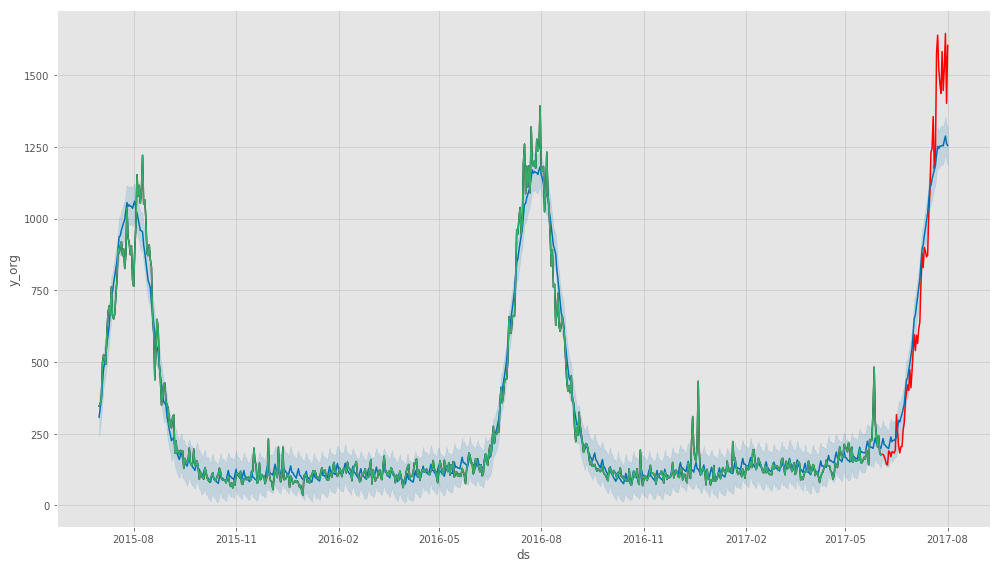

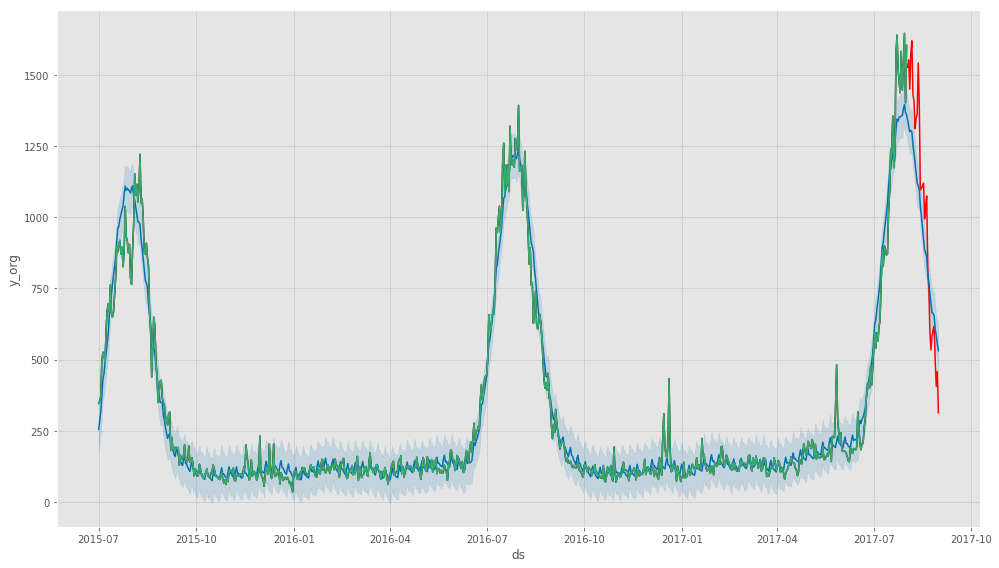

page_index 21678
v6_val 77.0634920635
smape_60_to_30 186.666666667
val_gain 109.603174603
smape_30_to_0 47.873015873
v6t_val 49.7142857143
test_gain -1.84126984127
nans_60_to_30 0.0
median_pred_60 0.0
median_pred_30 2.0


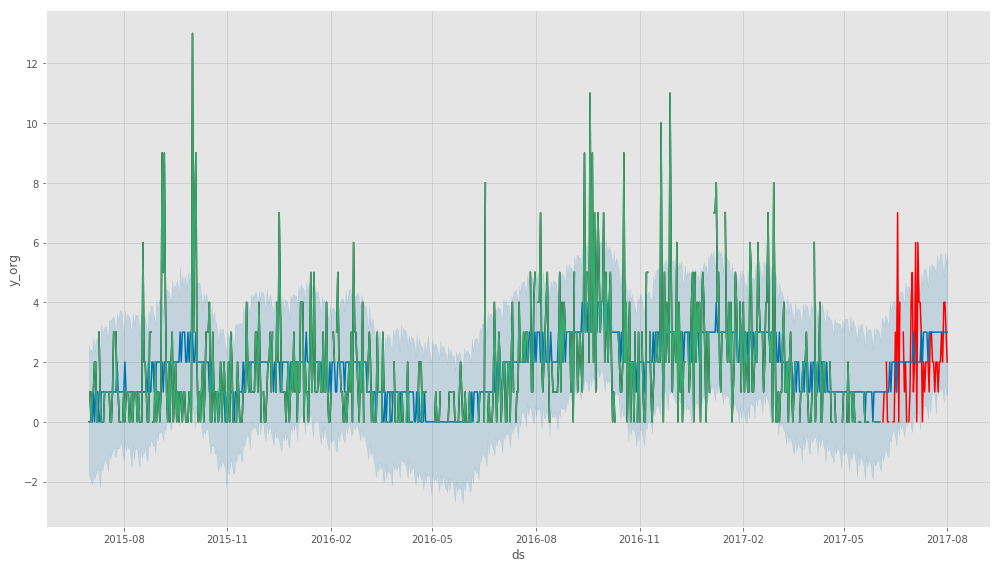

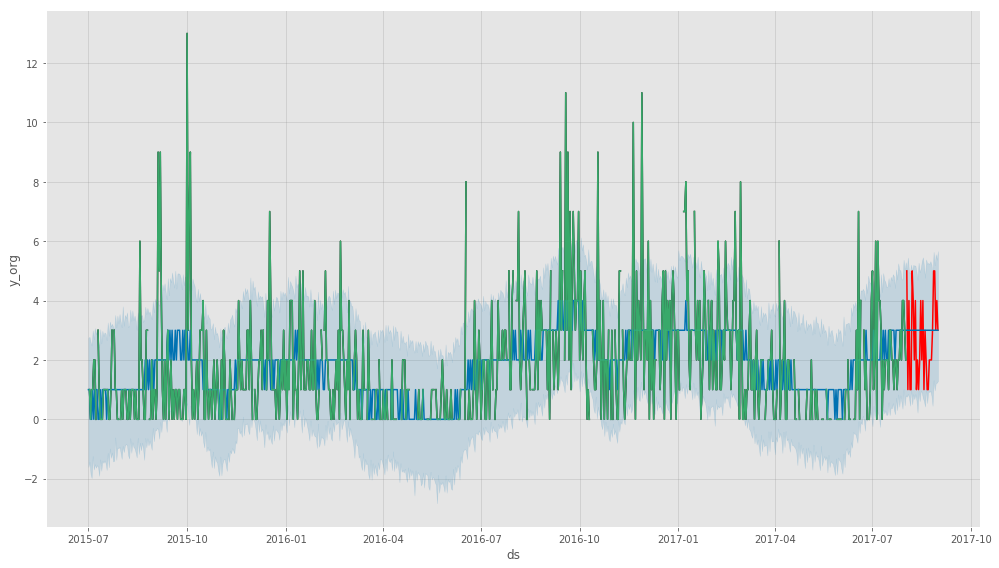

page_index 26201
v6_val 52.7681733291
smape_60_to_30 163.414899086
val_gain 110.646725756
smape_30_to_0 62.6436108664
v6t_val 54.0812530179
test_gain 8.56235784856
nans_60_to_30 0.0
median_pred_60 103.0
median_pred_30 1240.0


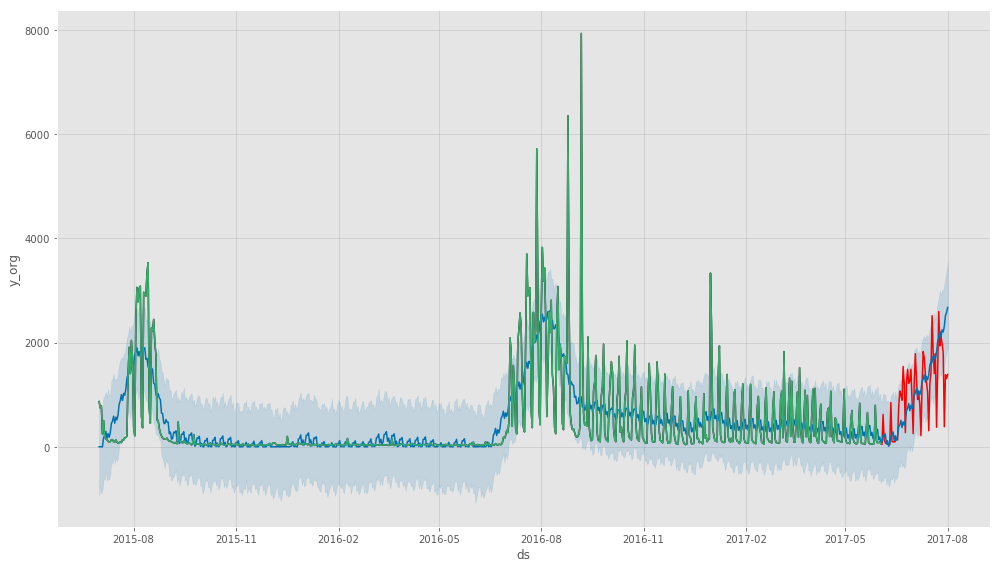

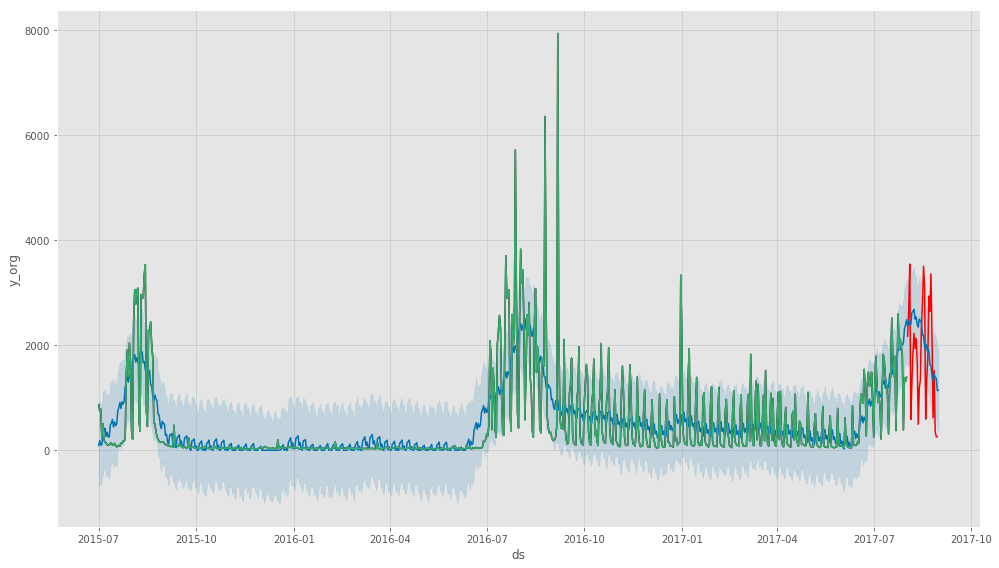

page_index 44555
v6_val 50.5503870895
smape_60_to_30 149.944849299
val_gain 99.3944622094
smape_30_to_0 59.8391630637
v6t_val 76.7343113108
test_gain -16.8951482471
nans_60_to_30 0.0
median_pred_60 618.0
median_pred_30 117.0


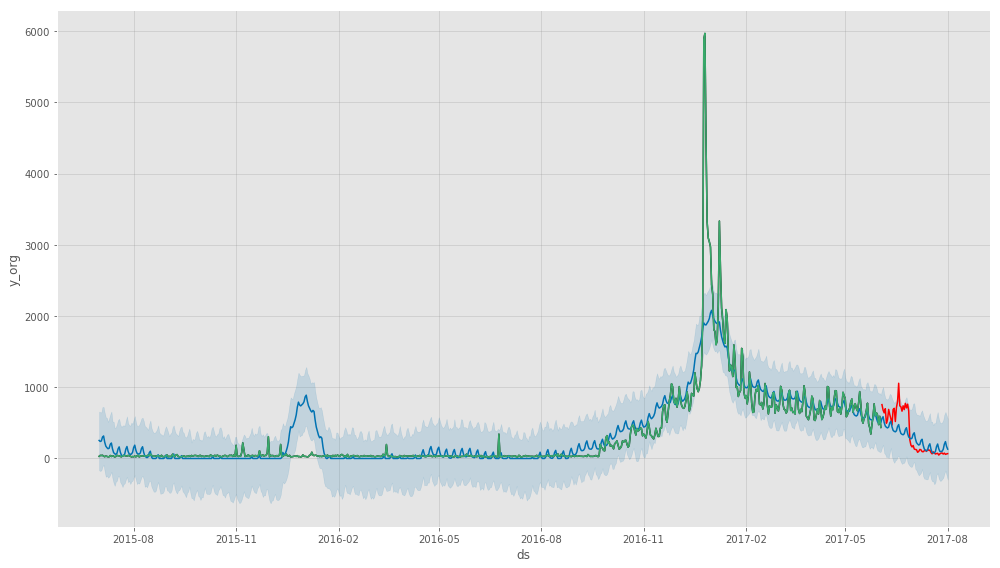

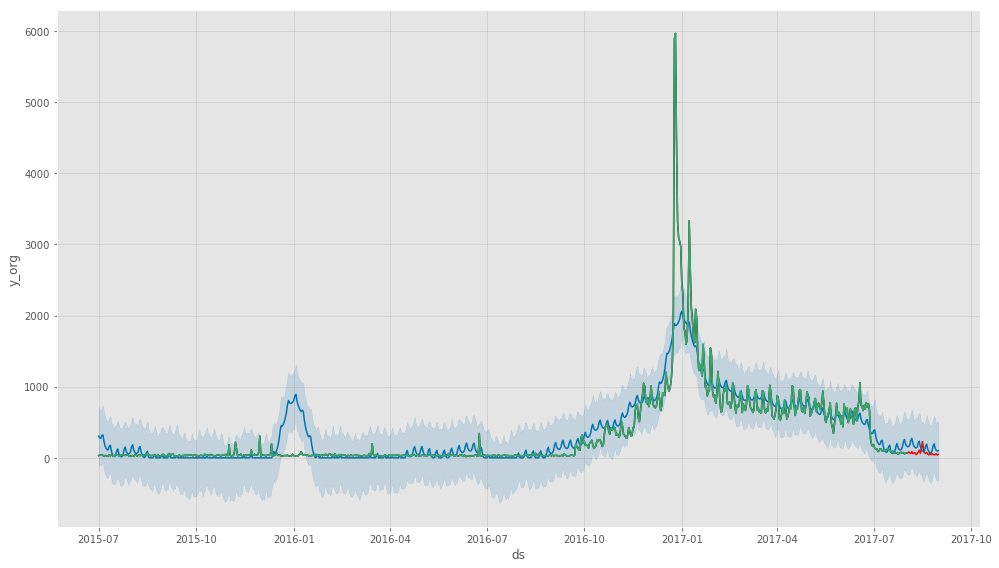

page_index 45736
v6_val 51.9316768705
smape_60_to_30 154.889033172
val_gain 102.957356302
smape_30_to_0 144.25708515
v6t_val 153.965547163
test_gain -9.70846201337
nans_60_to_30 0.0
median_pred_60 251.0
median_pred_30 44.0


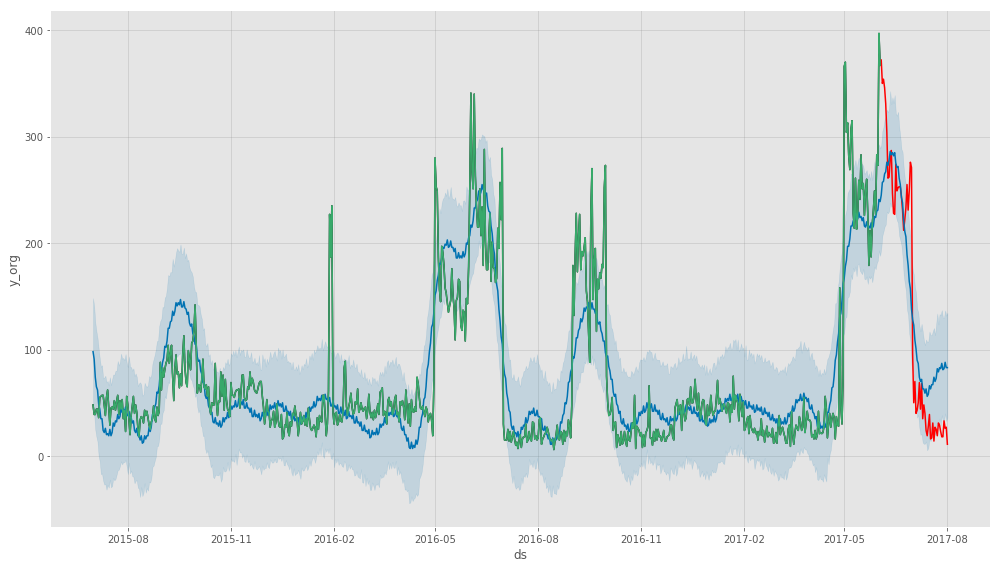

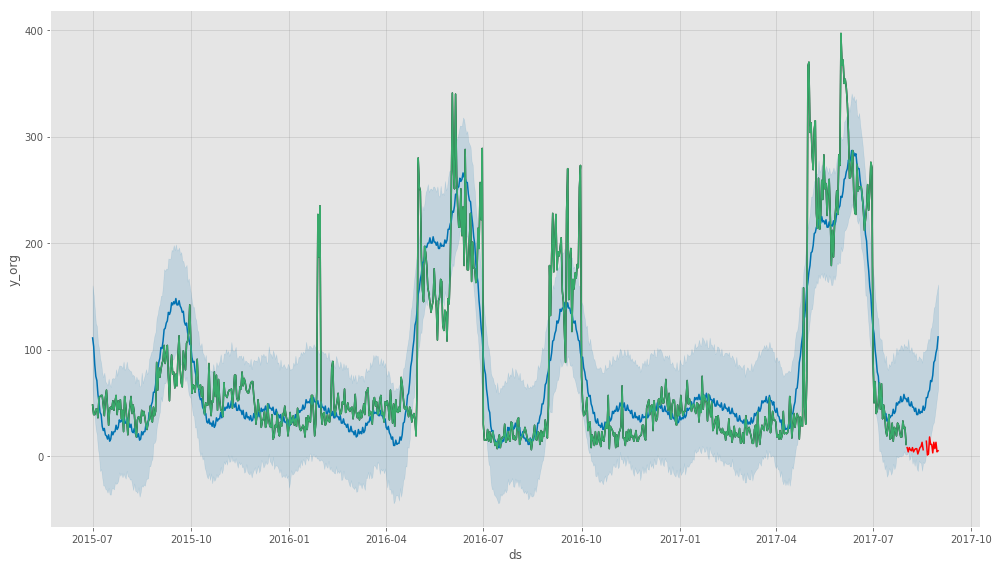

page_index 46262
v6_val 51.1588879152
smape_60_to_30 158.284166669
val_gain 107.125278754
smape_30_to_0 111.016289986
v6t_val 89.9029375766
test_gain 21.113352409
nans_60_to_30 0.0
median_pred_60 161.0
median_pred_30 29.0


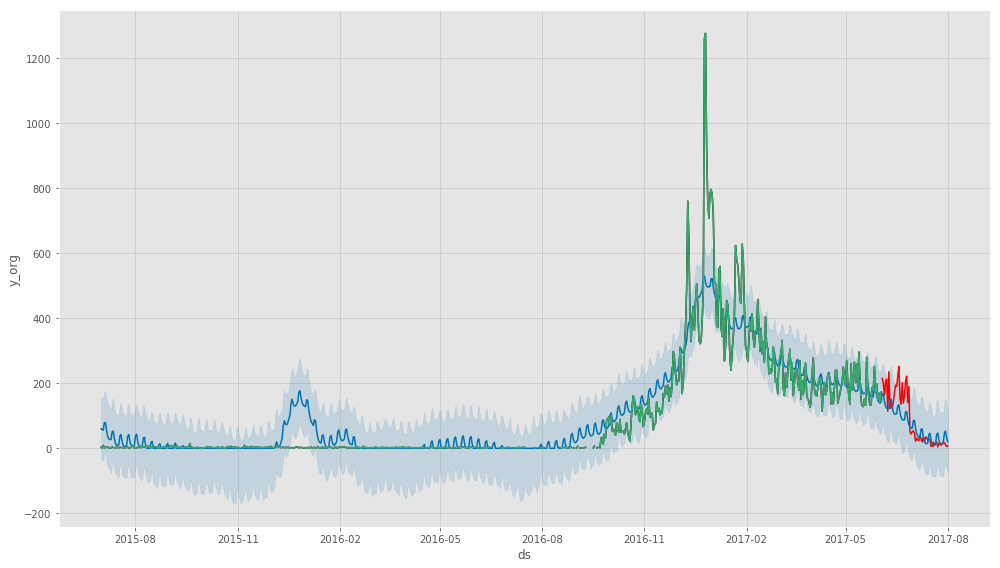

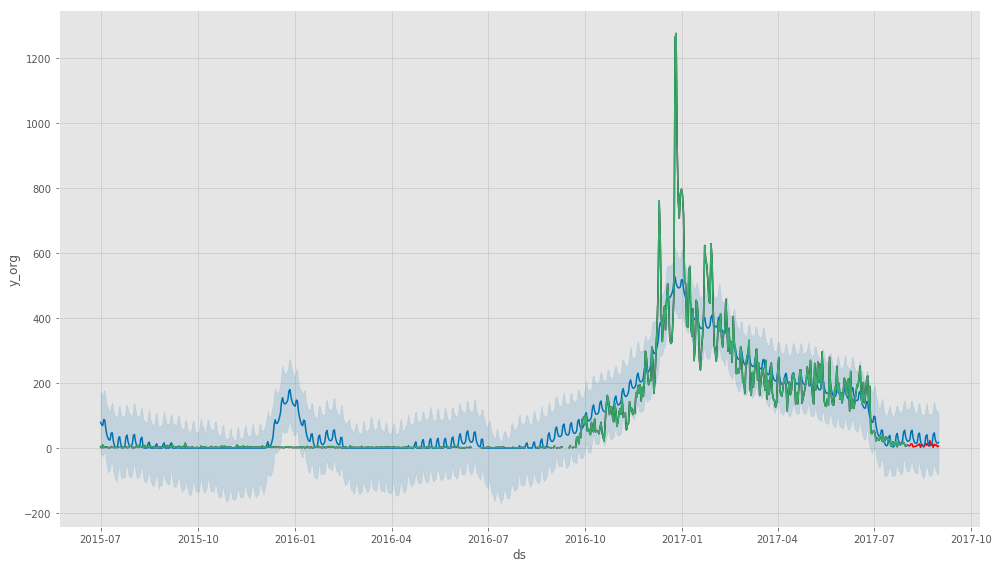

page_index 51332
v6_val 58.6302341851
smape_60_to_30 163.330538894
val_gain 104.700304709
smape_30_to_0 64.9844786421
v6t_val 48.7973553692
test_gain 16.1871232728
nans_60_to_30 0.0
median_pred_60 37.0
median_pred_30 451.0


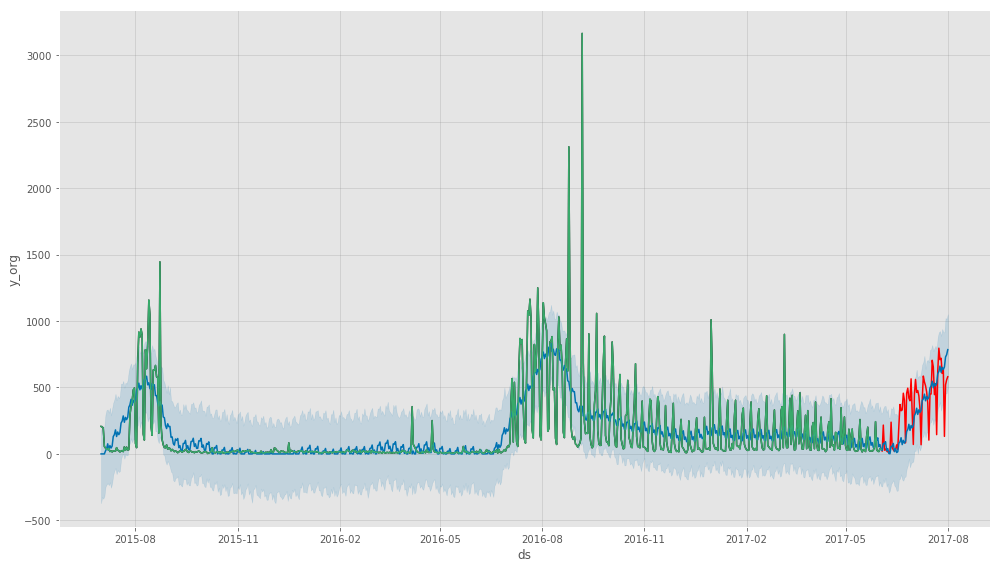

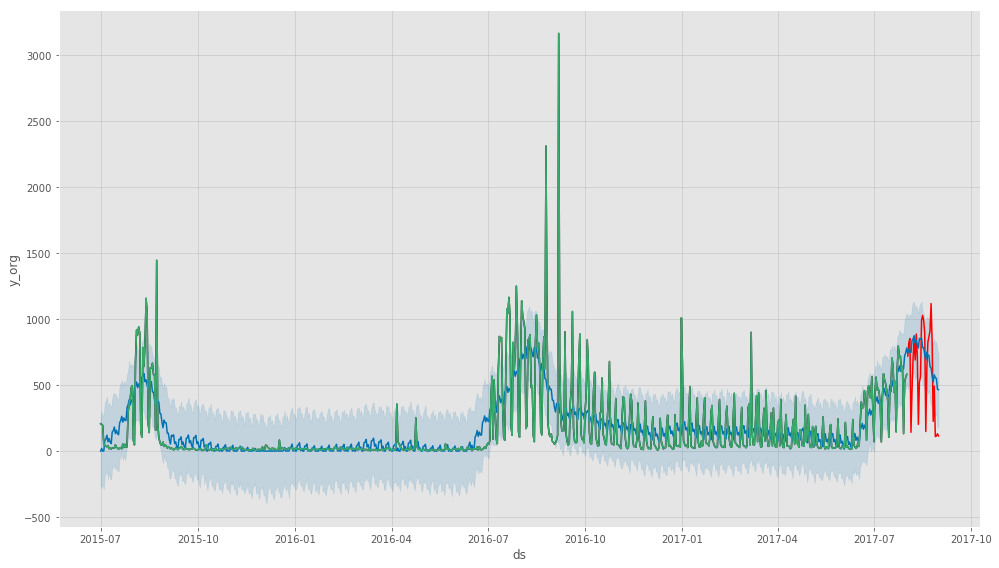

page_index 52276
v6_val 57.6214140812
smape_60_to_30 171.648797677
val_gain 114.027383596
smape_30_to_0 69.2532610879
v6t_val 59.2181878435
test_gain 10.0350732444
nans_60_to_30 0.0
median_pred_60 58.0
median_pred_30 971.0


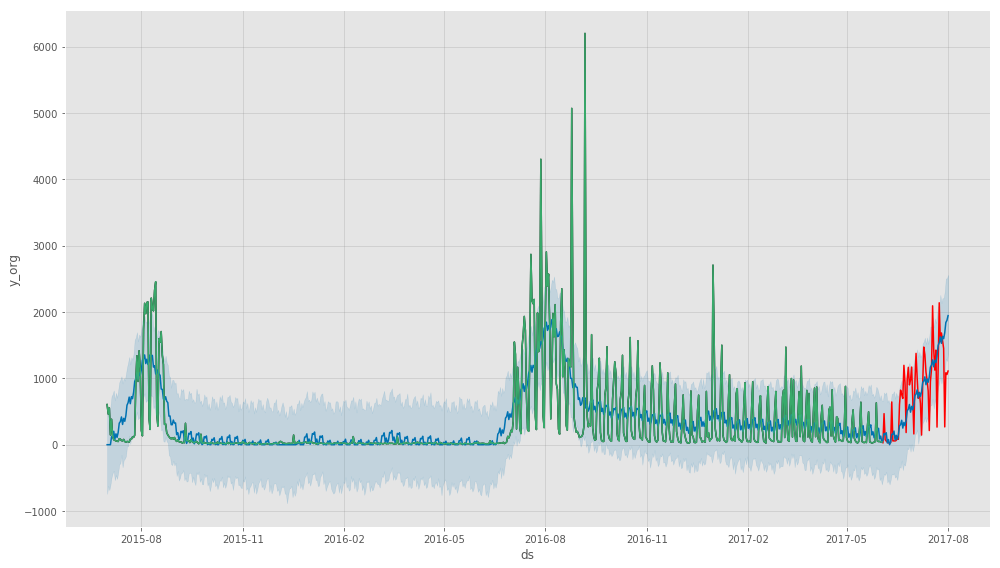

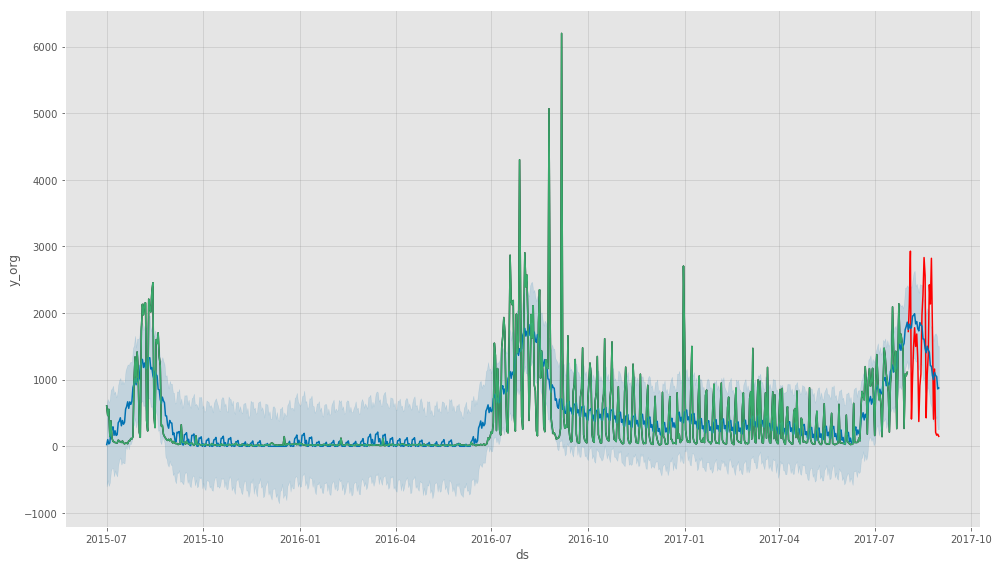

page_index 54325
v6_val 51.6331045733
smape_60_to_30 145.098649443
val_gain 93.4655448701
smape_30_to_0 104.177858485
v6t_val 73.4269942765
test_gain 30.7508642089
nans_60_to_30 0.0
median_pred_60 104.0
median_pred_30 543.0


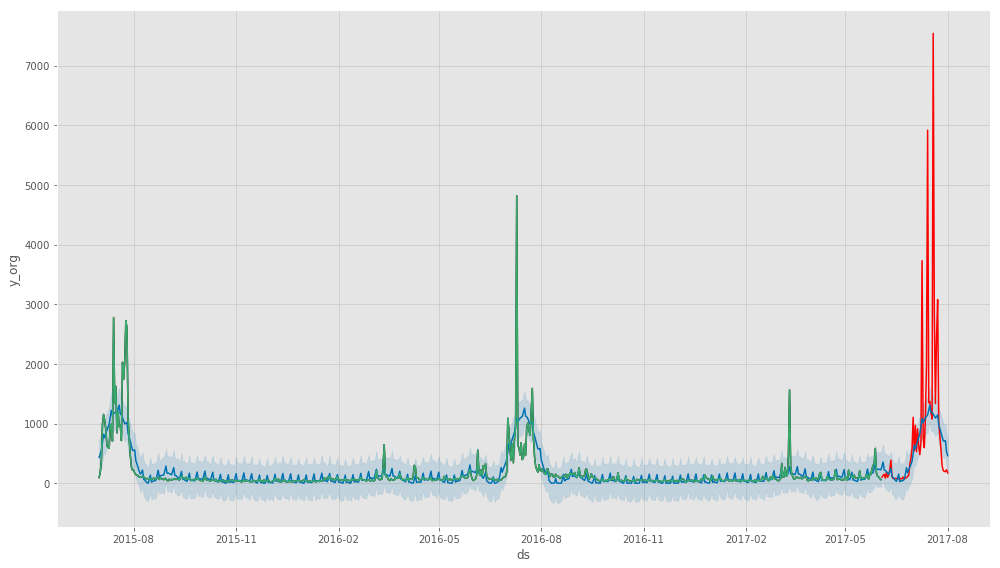

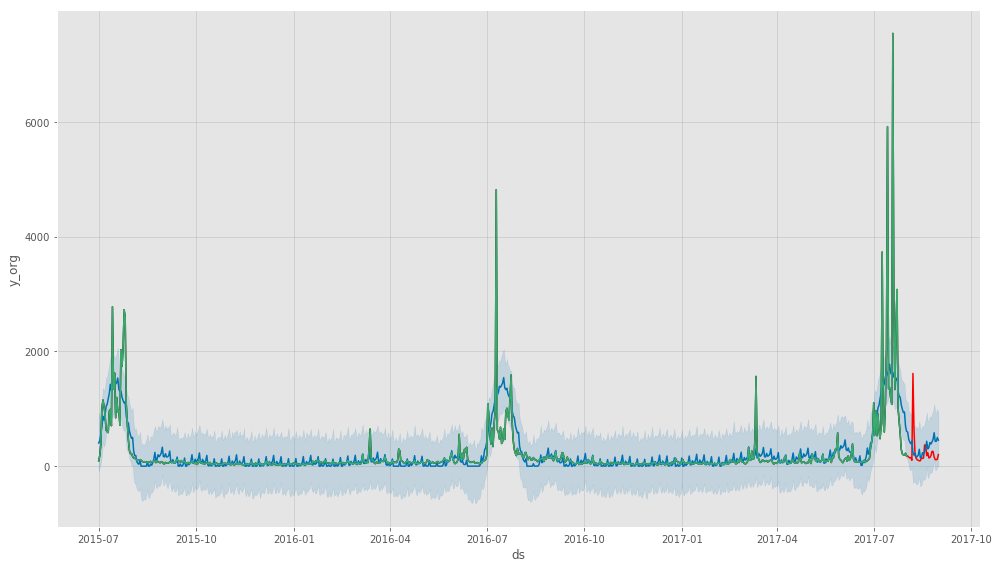

page_index 55366
v6_val 56.0395891805
smape_60_to_30 149.697161423
val_gain 93.6575722425
smape_30_to_0 55.0376664181
v6t_val 44.8601435025
test_gain 10.1775229156
nans_60_to_30 0.0
median_pred_60 268.0
median_pred_30 2298.0


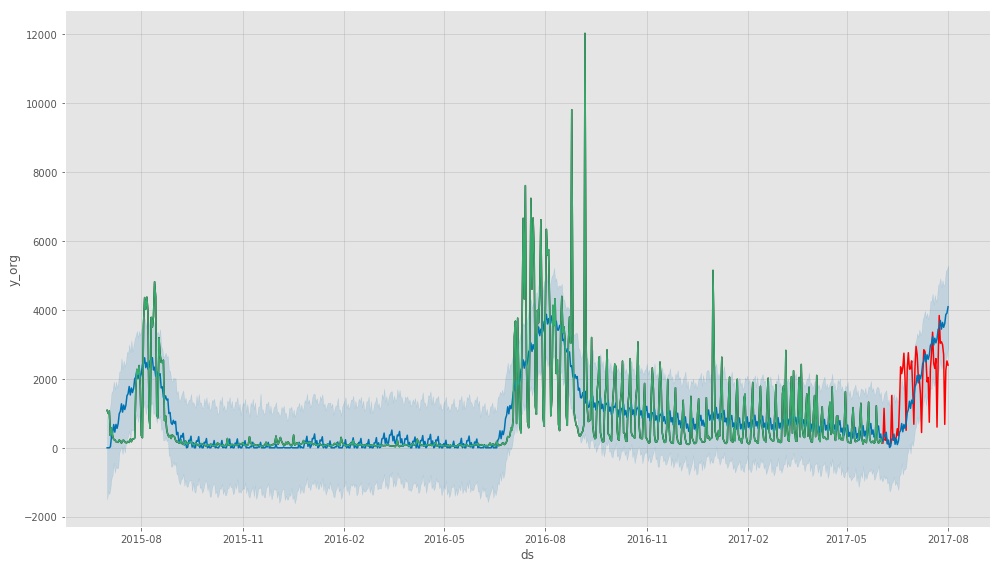

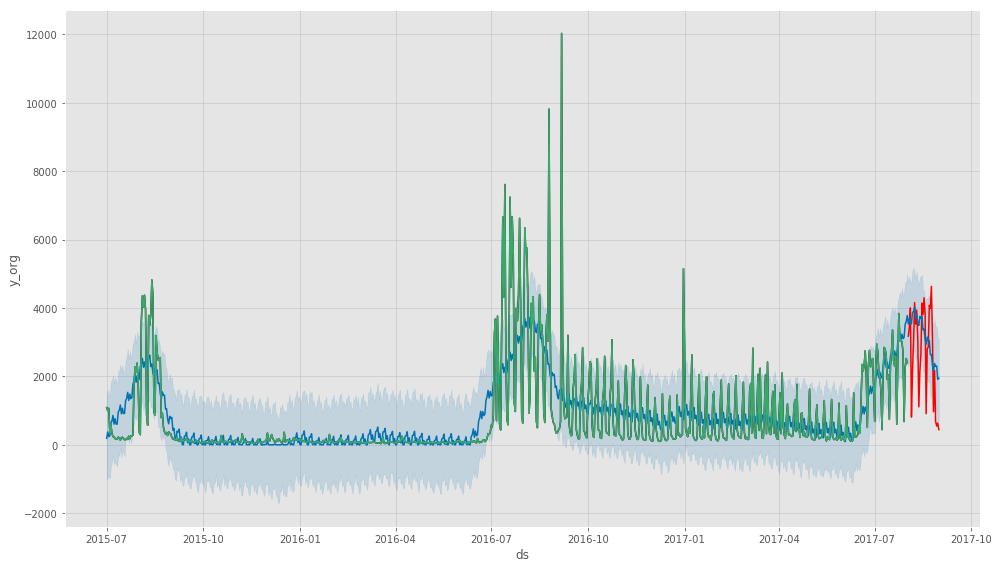

page_index 56504
v6_val 19.4673185258
smape_60_to_30 148.86114429
val_gain 129.393825764
smape_30_to_0 69.3068554609
v6t_val 14.3976061332
test_gain 54.9092493277
nans_60_to_30 0.0
median_pred_60 187.0
median_pred_30 845.0


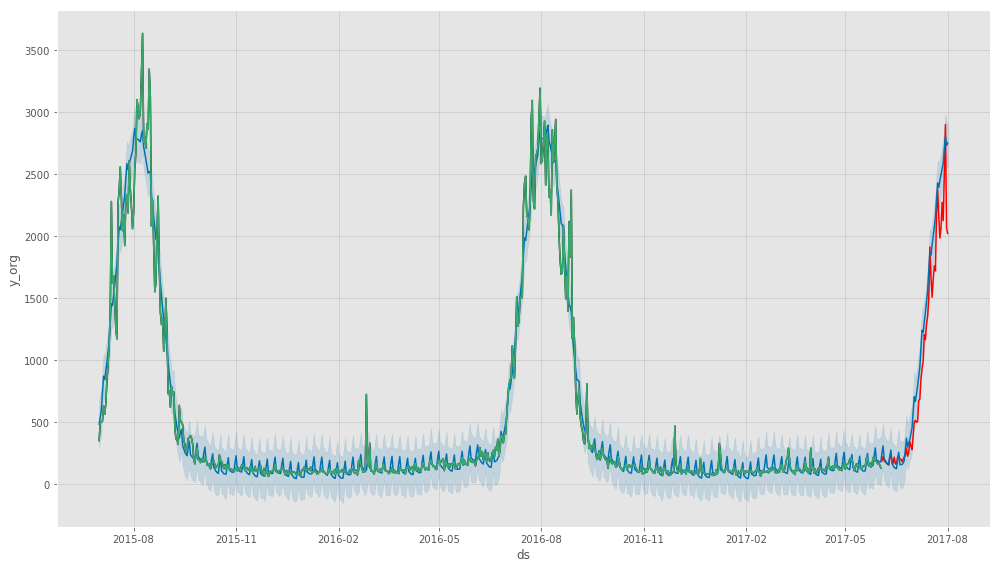

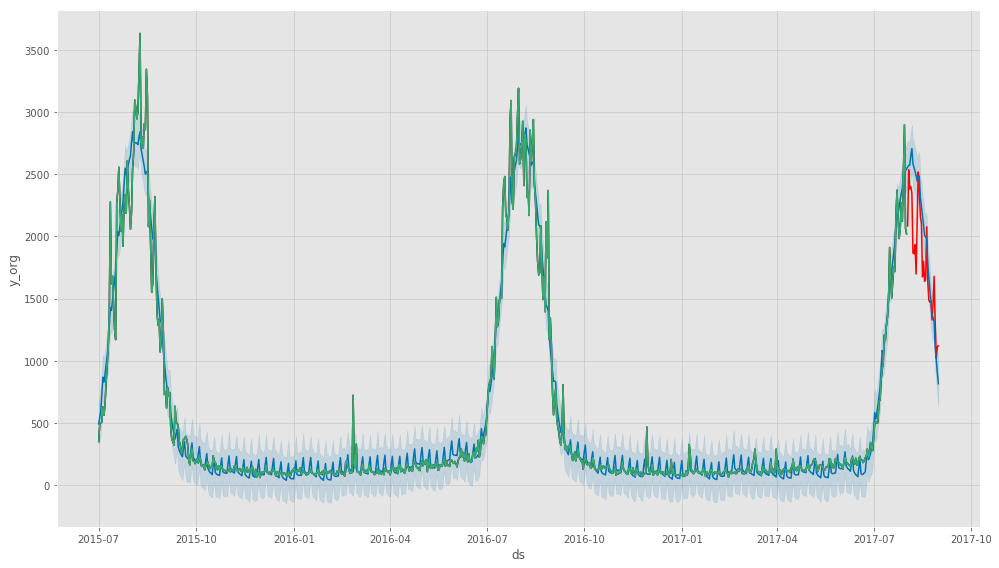

page_index 59259
v6_val 49.599349687
smape_60_to_30 159.126882262
val_gain 109.527532575
smape_30_to_0 91.0220819726
v6t_val 38.7757513595
test_gain 52.2463306131
nans_60_to_30 0.0
median_pred_60 115.0
median_pred_30 702.0


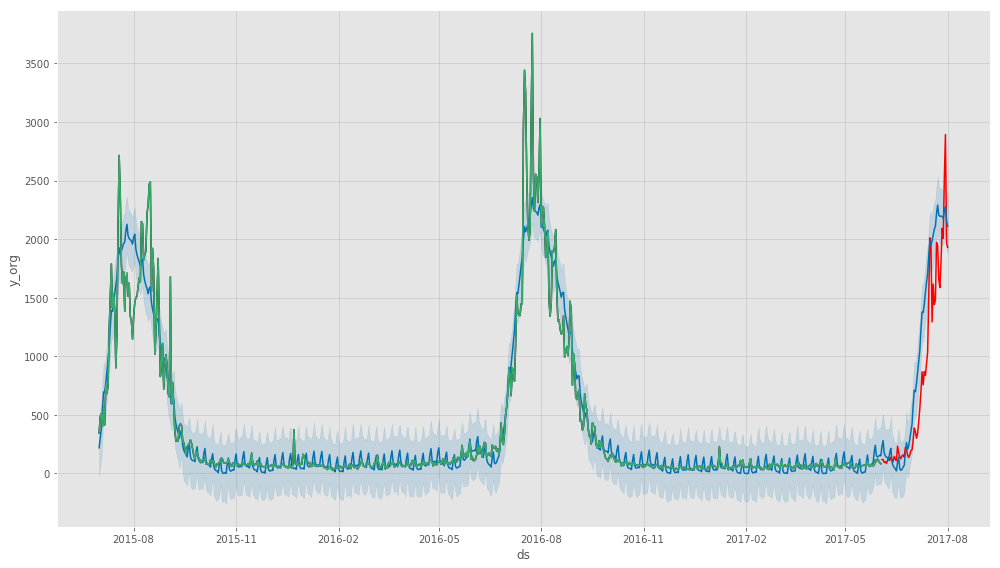

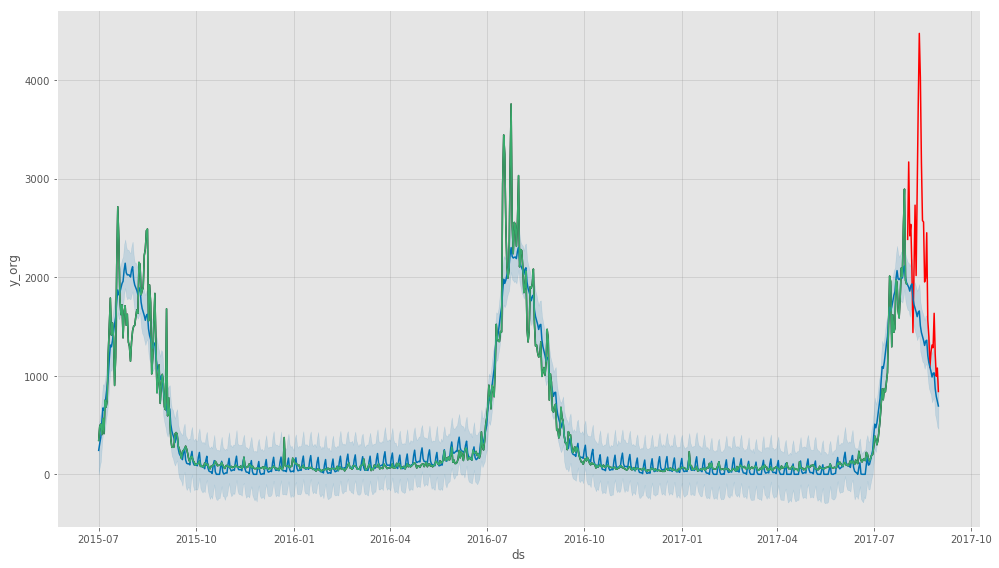

page_index 72358
v6_val 59.1033816909
smape_60_to_30 171.705526675
val_gain 112.602144984
smape_30_to_0 148.735220028
v6t_val 149.909799288
test_gain -1.17457926058
nans_60_to_30 0.0
median_pred_60 102.0
median_pred_30 1172.0


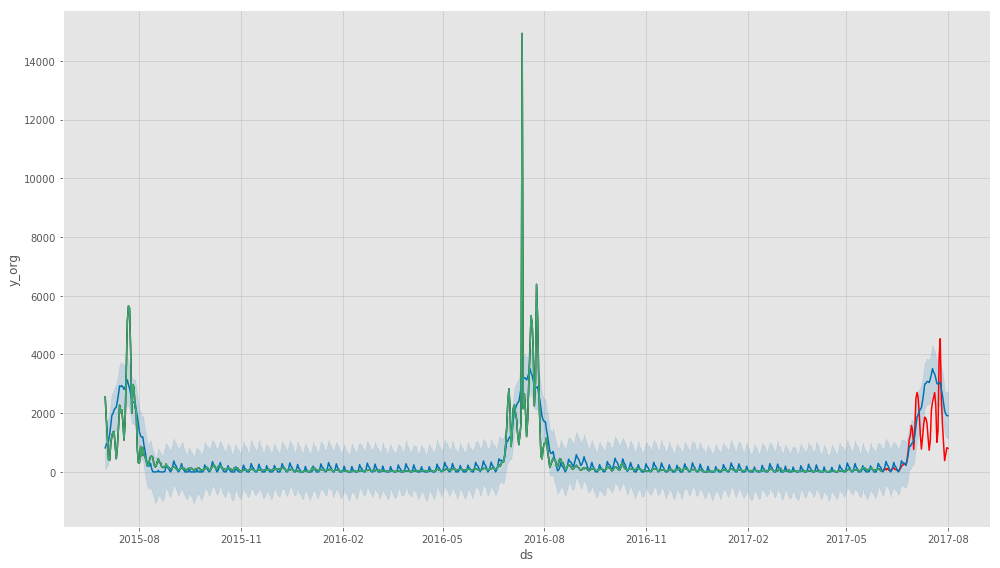

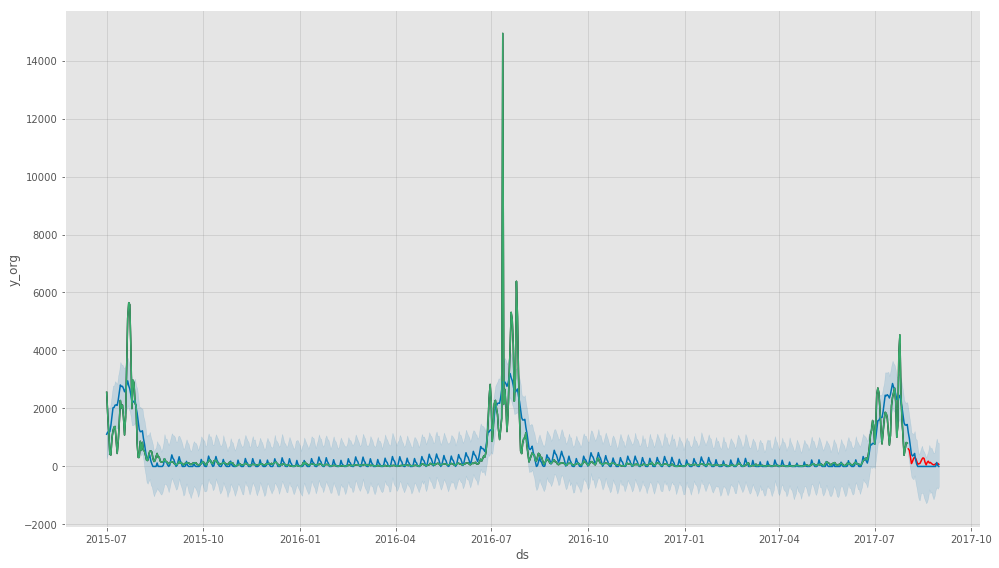

page_index 78171
v6_val 63.2794412781
smape_60_to_30 163.488576874
val_gain 100.209135596
smape_30_to_0 80.6721539554
v6t_val 84.1749439345
test_gain -3.5027899791
nans_60_to_30 0.0
median_pred_60 58.0
median_pred_30 9.0


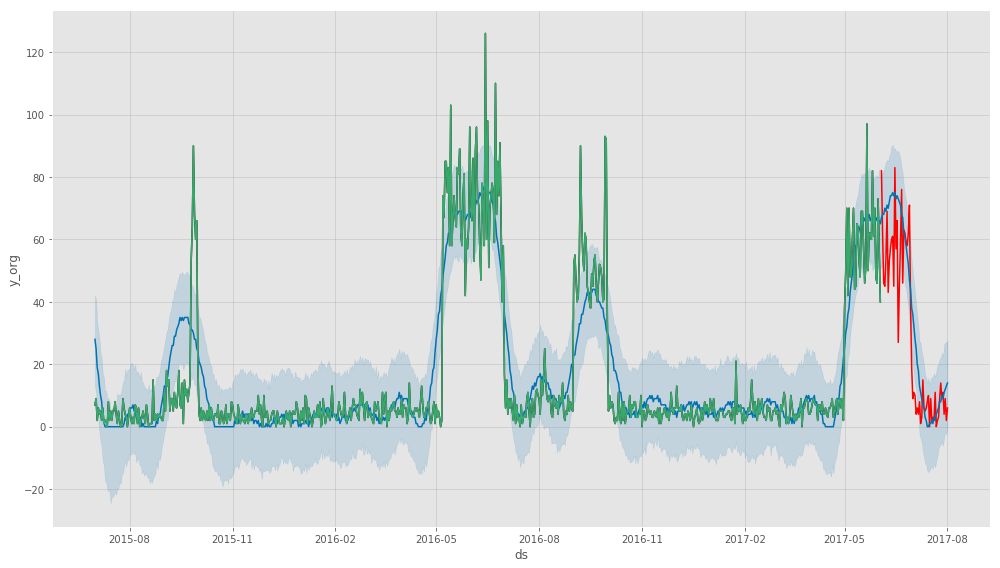

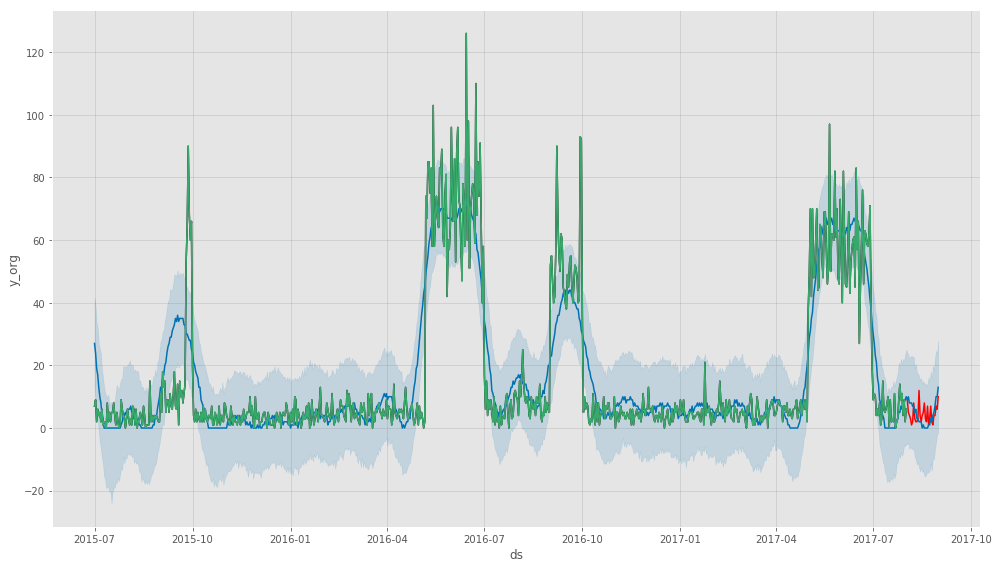

page_index 79710
v6_val 53.8716708156
smape_60_to_30 160.329102131
val_gain 106.457431316
smape_30_to_0 182.982614592
v6t_val 186.351292615
test_gain -3.36867802378
nans_60_to_30 0.0
median_pred_60 230.0
median_pred_30 32.0


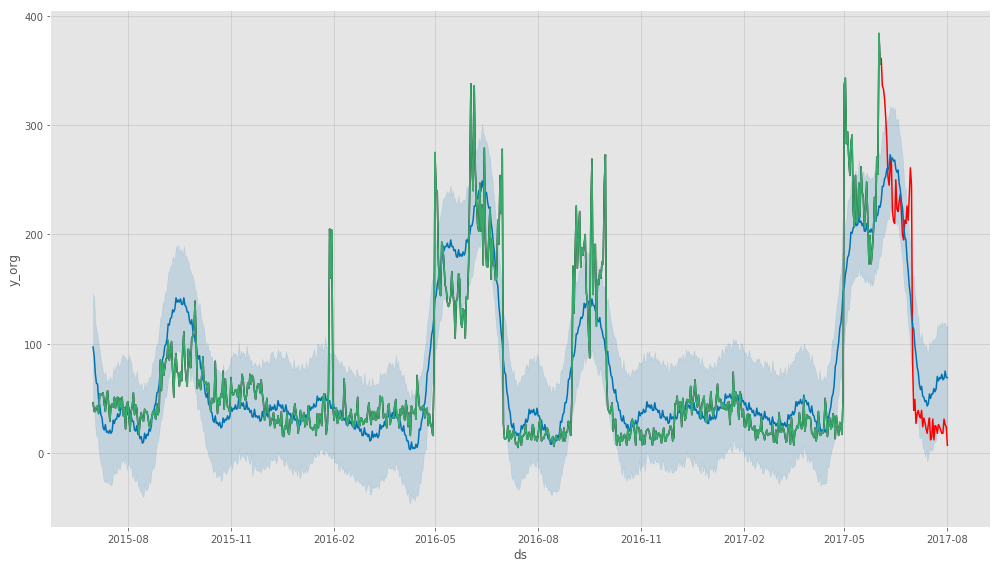

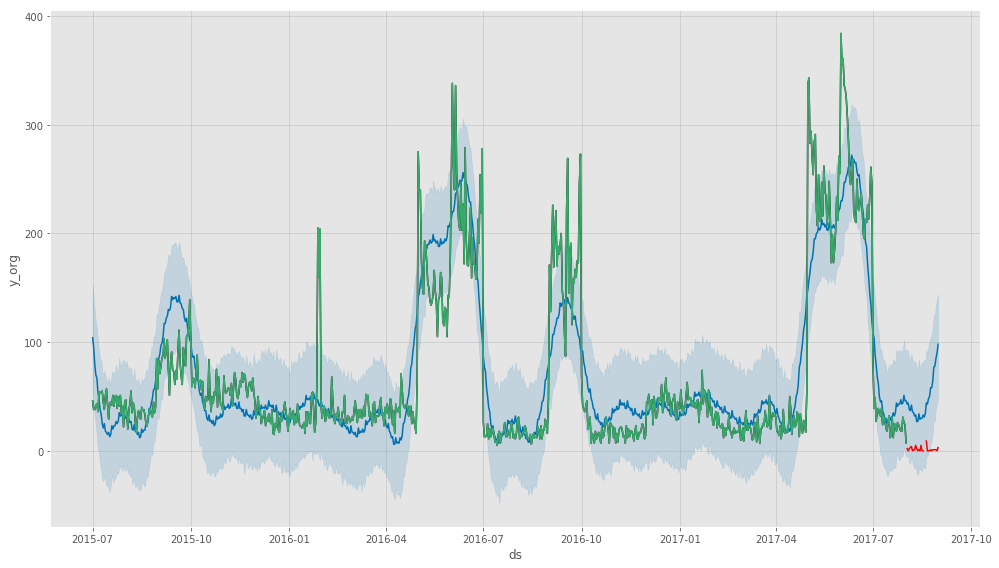

page_index 85610
v6_val 24.7543064311
smape_60_to_30 130.206301241
val_gain 105.45199481
smape_30_to_0 74.6825018535
v6t_val 25.2360853641
test_gain 49.4464164893
nans_60_to_30 0.0
median_pred_60 137.0
median_pred_30 362.0


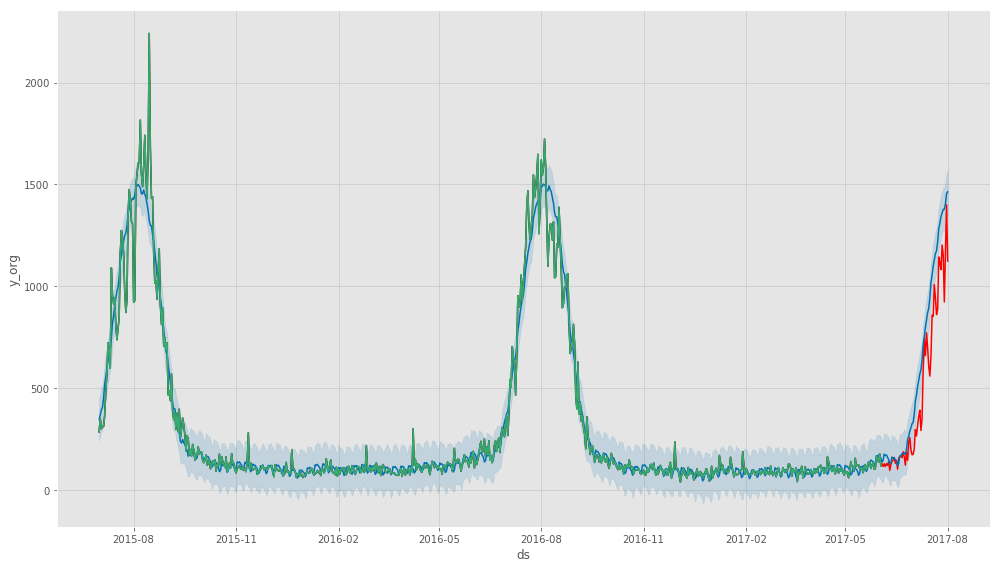

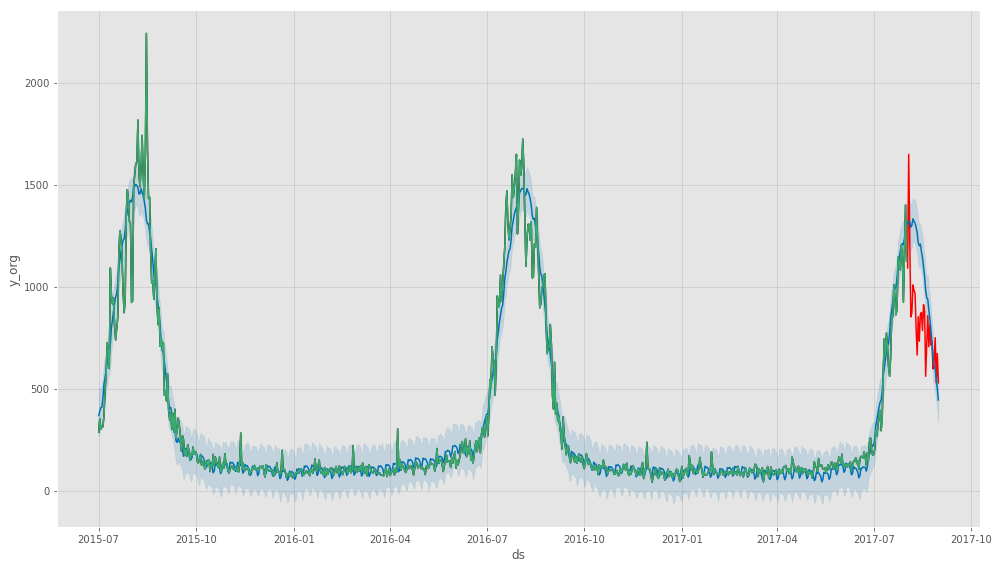

page_index 92534
v6_val 60.9684222617
smape_60_to_30 157.184503026
val_gain 96.2160807647
smape_30_to_0 75.0188516618
v6t_val 29.1492964947
test_gain 45.8695551672
nans_60_to_30 0.0
median_pred_60 338.0
median_pred_30 1810.0


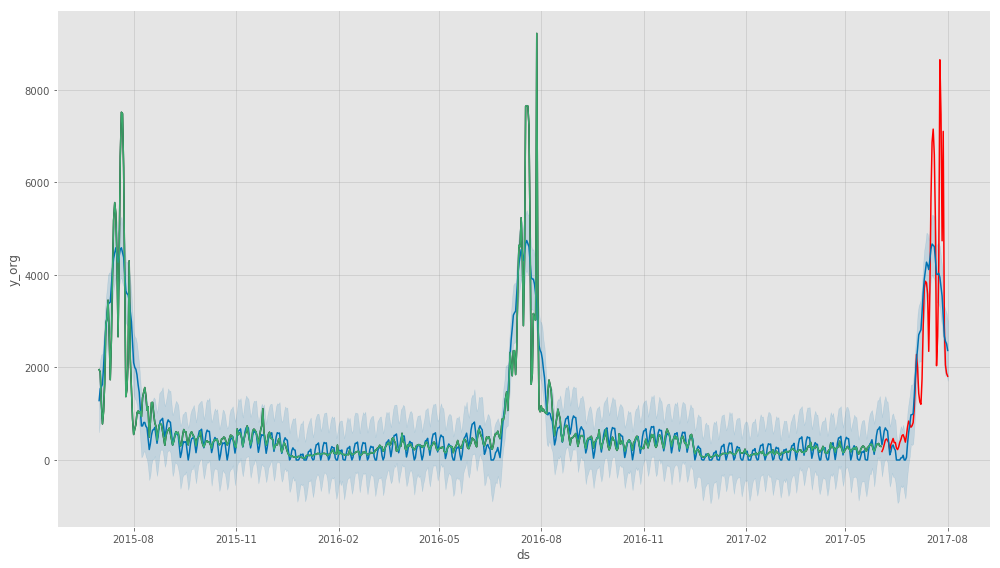

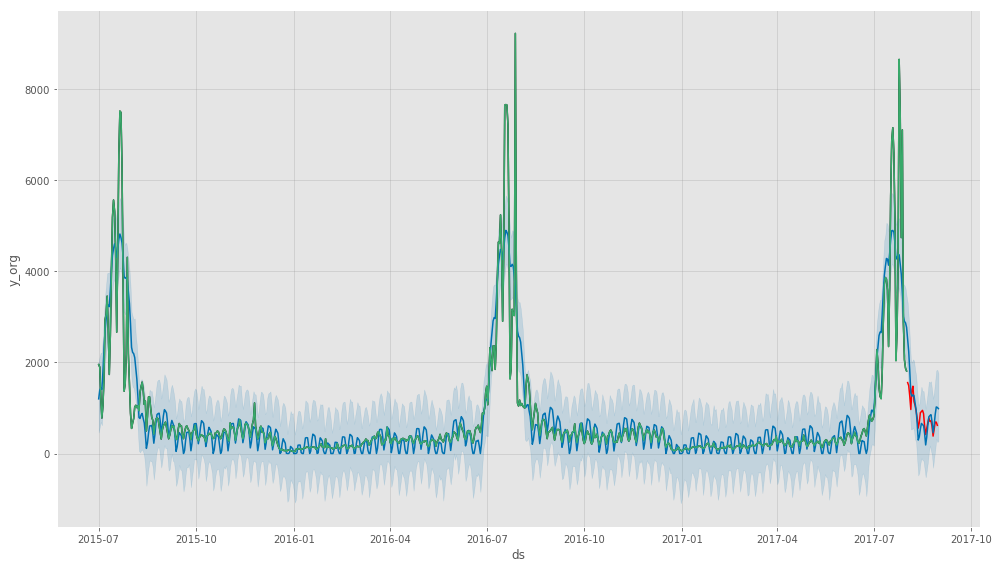

page_index 93422
v6_val 50.2129873586
smape_60_to_30 170.720656223
val_gain 120.507668864
smape_30_to_0 141.862495632
v6t_val 110.947454701
test_gain 30.9150409313
nans_60_to_30 0.0
median_pred_60 177.0
median_pred_30 1825.0


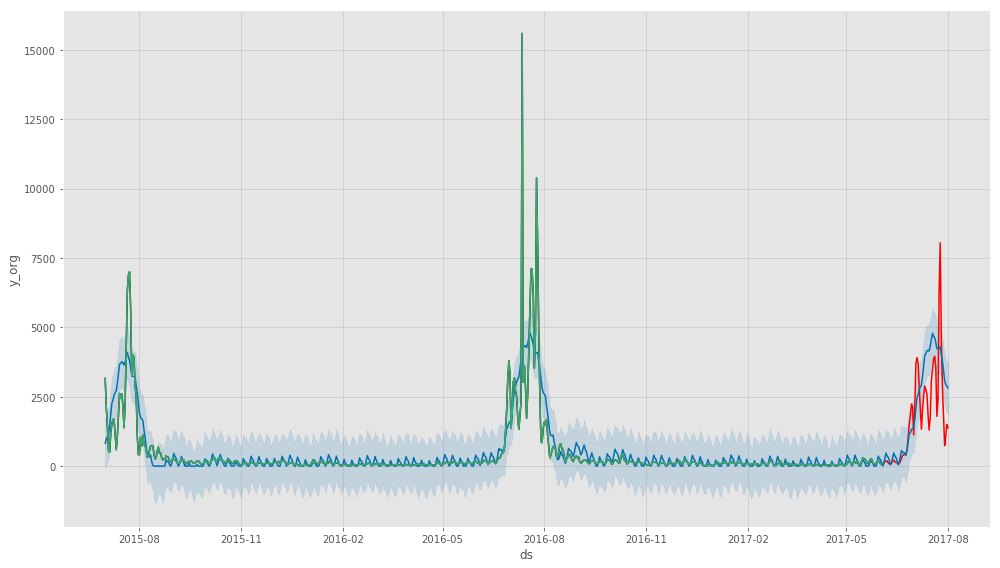

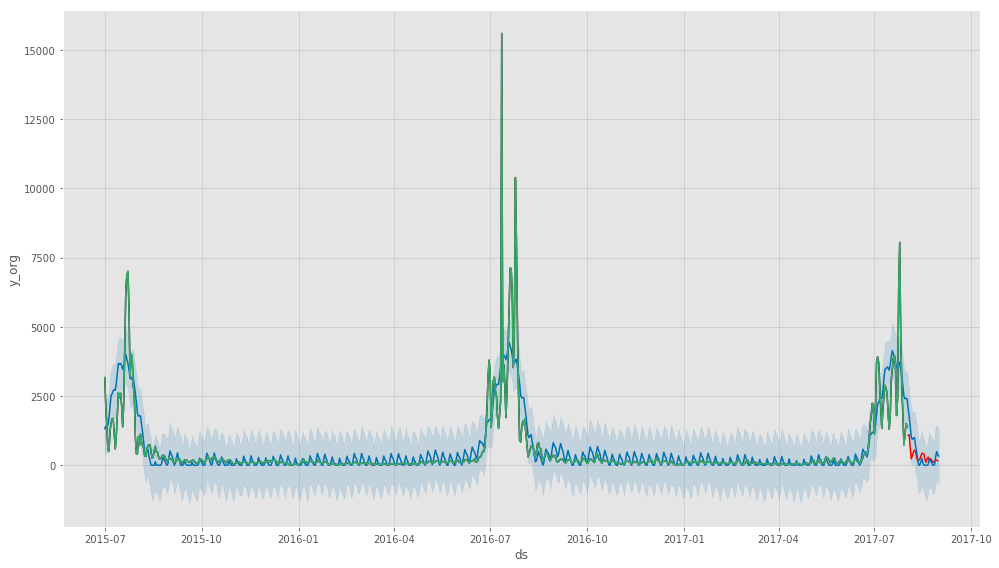

page_index 93762
v6_val 62.6706593972
smape_60_to_30 169.433084305
val_gain 106.762424908
smape_30_to_0 143.625807446
v6t_val 140.294063909
test_gain 3.33174353674
nans_60_to_30 0.0
median_pred_60 176.0
median_pred_30 1397.0


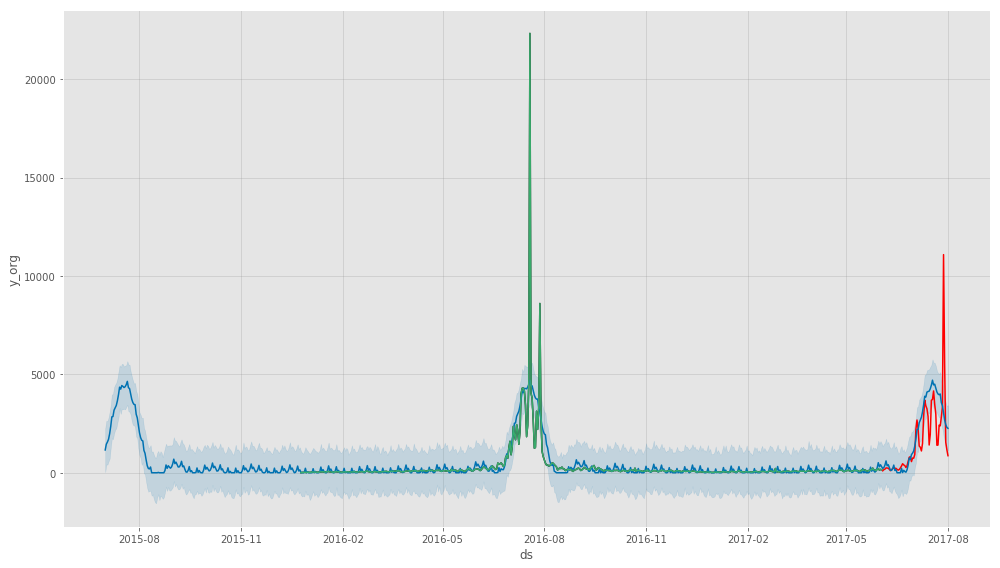

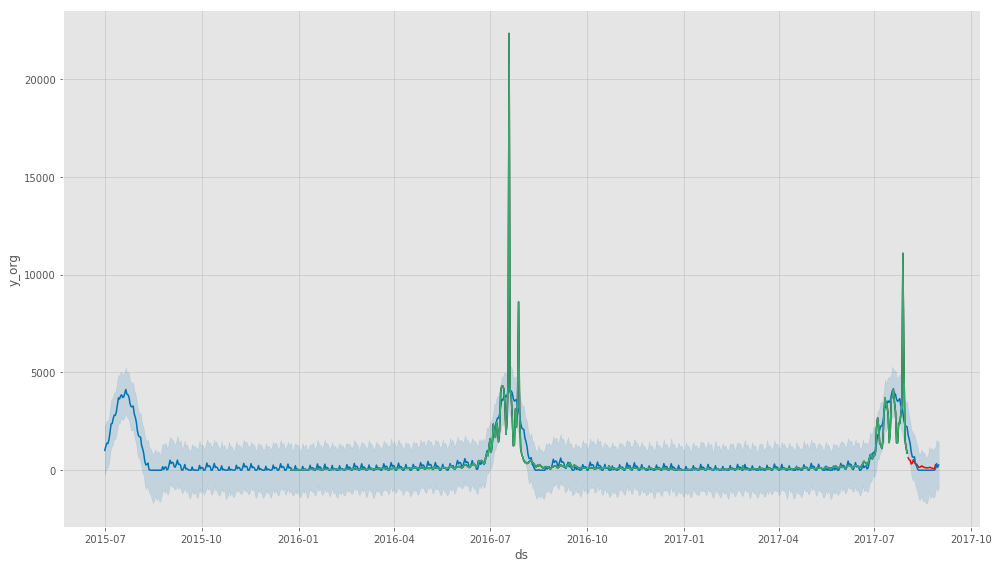

page_index 96830
v6_val 26.933234885
smape_60_to_30 124.143202212
val_gain 97.2099673268
smape_30_to_0 19.579295344
v6t_val 33.7177381787
test_gain -14.1384428347
nans_60_to_30 0.0
median_pred_60 1355.0
median_pred_30 356.0


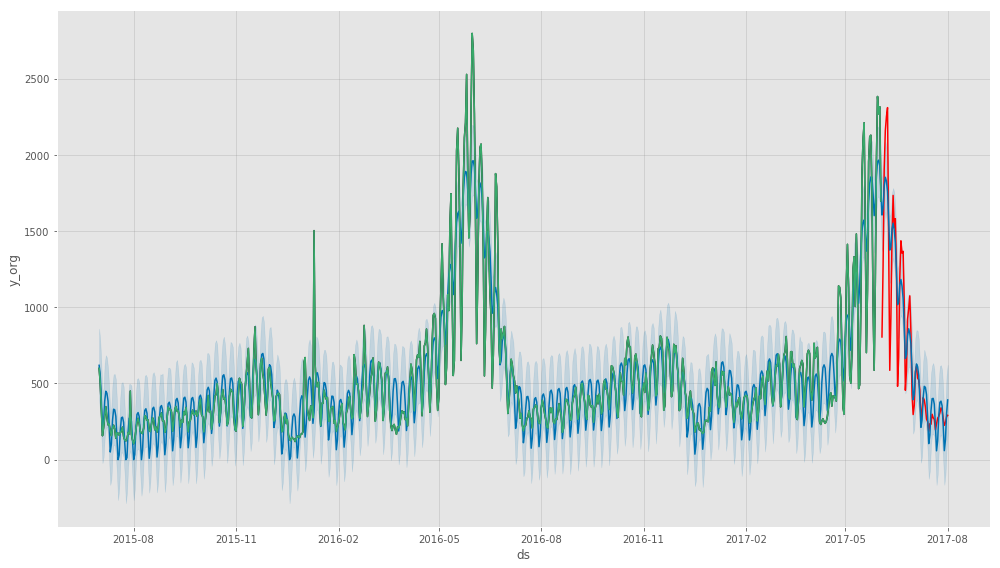

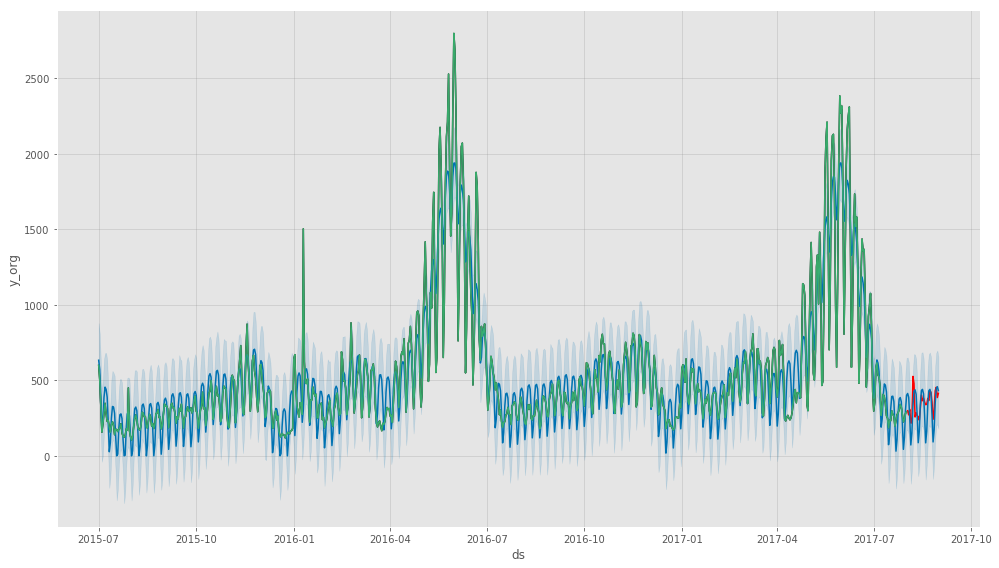

page_index 119529
v6_val 19.4305245956
smape_60_to_30 143.828758732
val_gain 124.398234137
smape_30_to_0 77.9719276062
v6t_val 16.2989181956
test_gain 61.6730094106
nans_60_to_30 0.0
median_pred_60 319.0
median_pred_30 1146.0


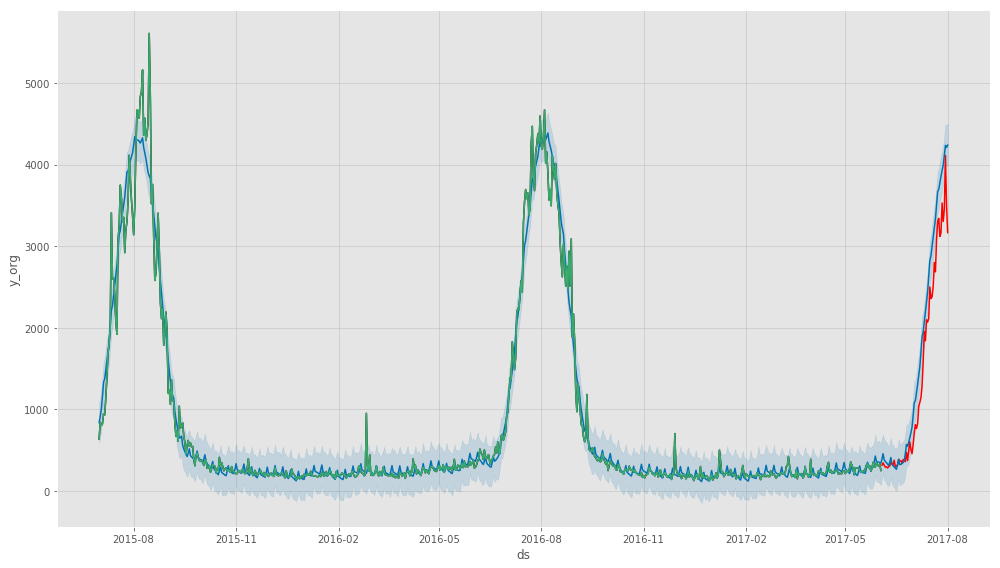

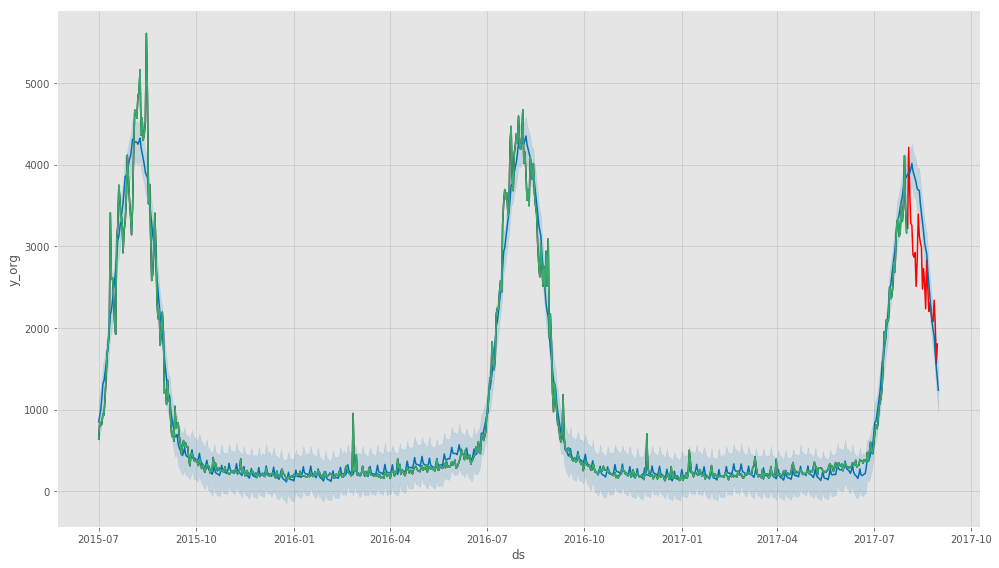

page_index 122358
v6_val 42.1084568896
smape_60_to_30 155.270195104
val_gain 113.161738214
smape_30_to_0 98.2655305989
v6t_val 33.1671247525
test_gain 65.0984058463
nans_60_to_30 0.0
median_pred_60 176.0
median_pred_30 914.0


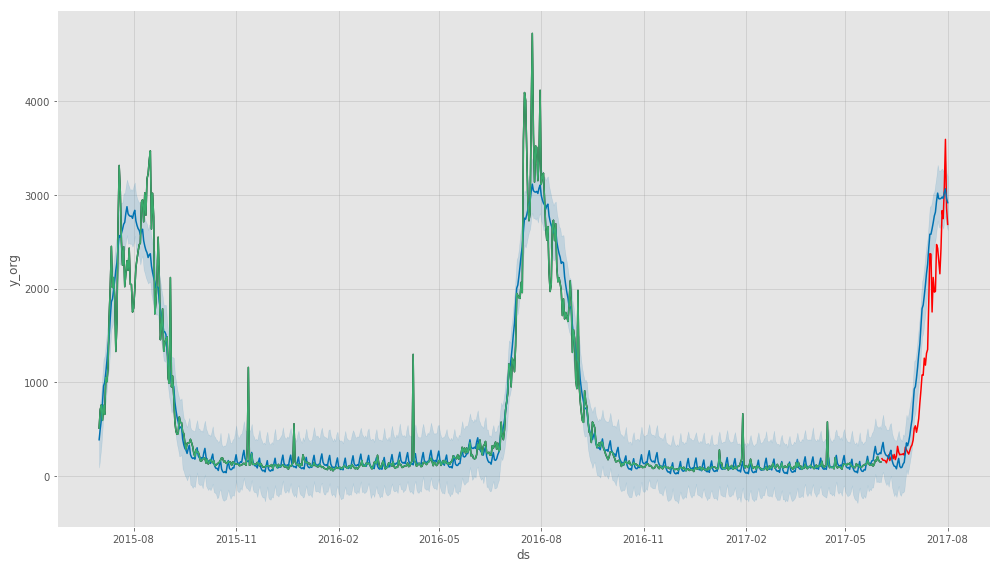

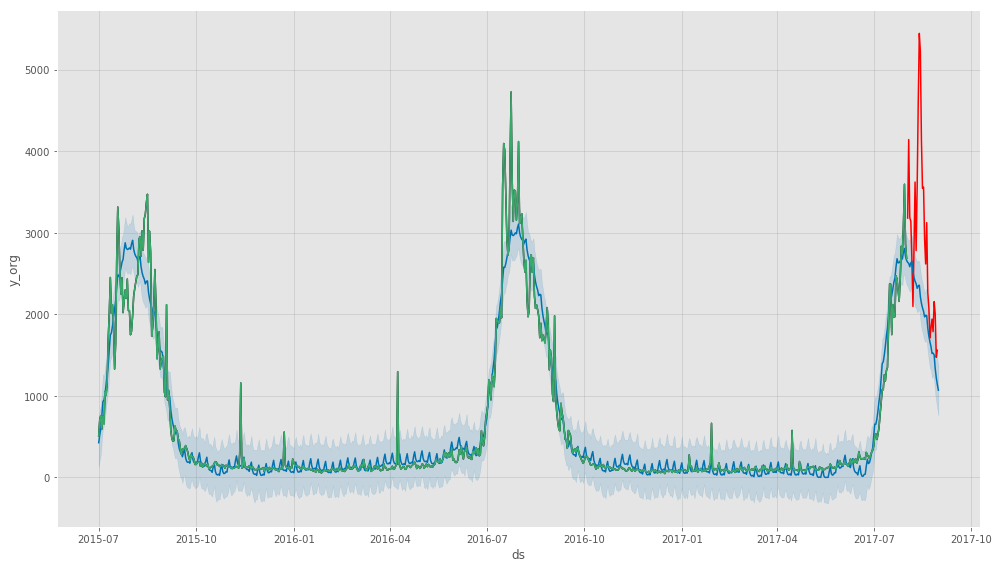

page_index 132771
v6_val 33.9847007811
smape_60_to_30 140.68135909
val_gain 106.696658309
smape_30_to_0 75.569392613
v6t_val 19.7156915948
test_gain 55.8537010183
nans_60_to_30 0.0
median_pred_60 24.0
median_pred_30 78.0


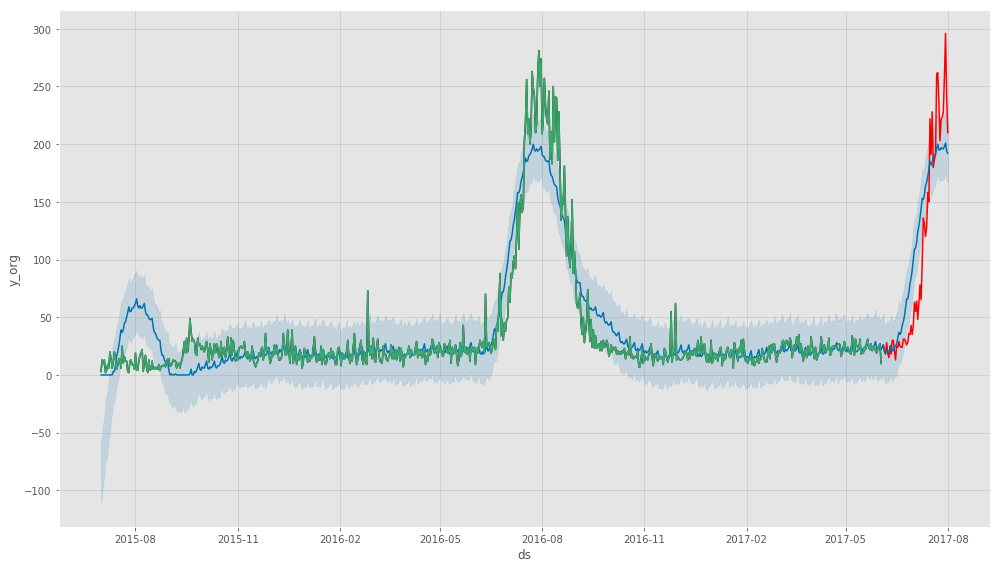

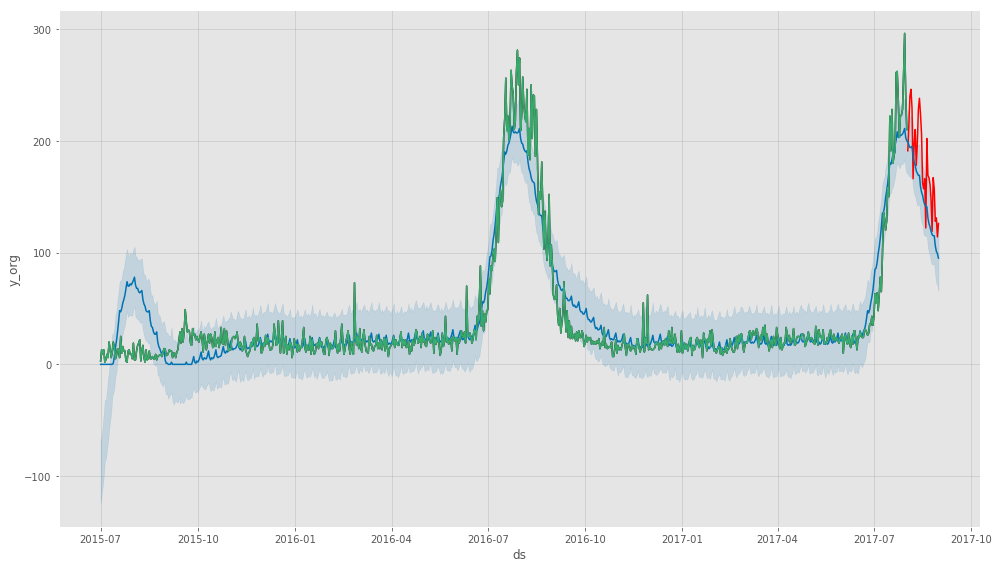

page_index 135605
v6_val 48.1249743112
smape_60_to_30 147.447236491
val_gain 99.3222621796
smape_30_to_0 97.9061168002
v6t_val 59.5671433207
test_gain 38.3389734794
nans_60_to_30 0.0
median_pred_60 15.0
median_pred_30 66.0


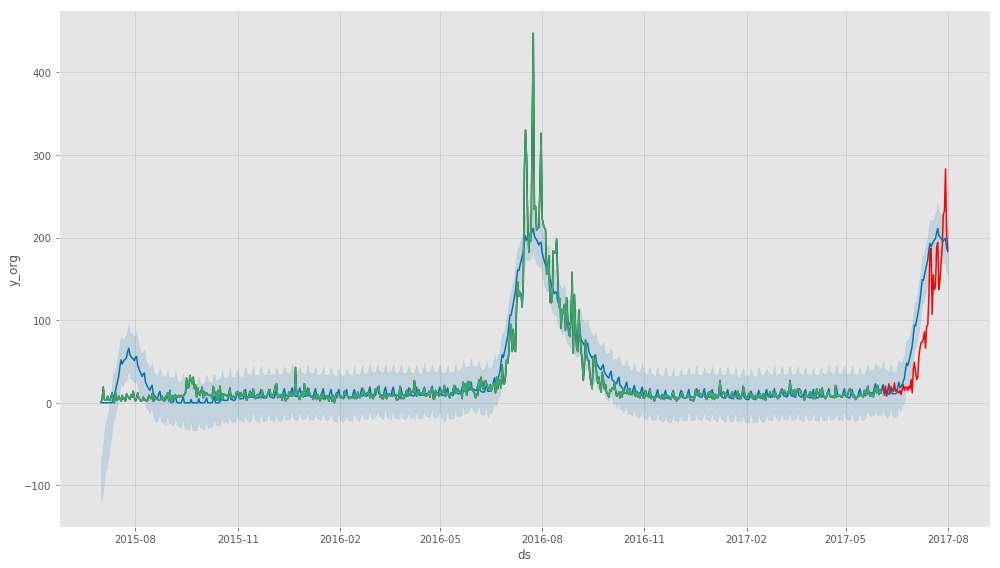

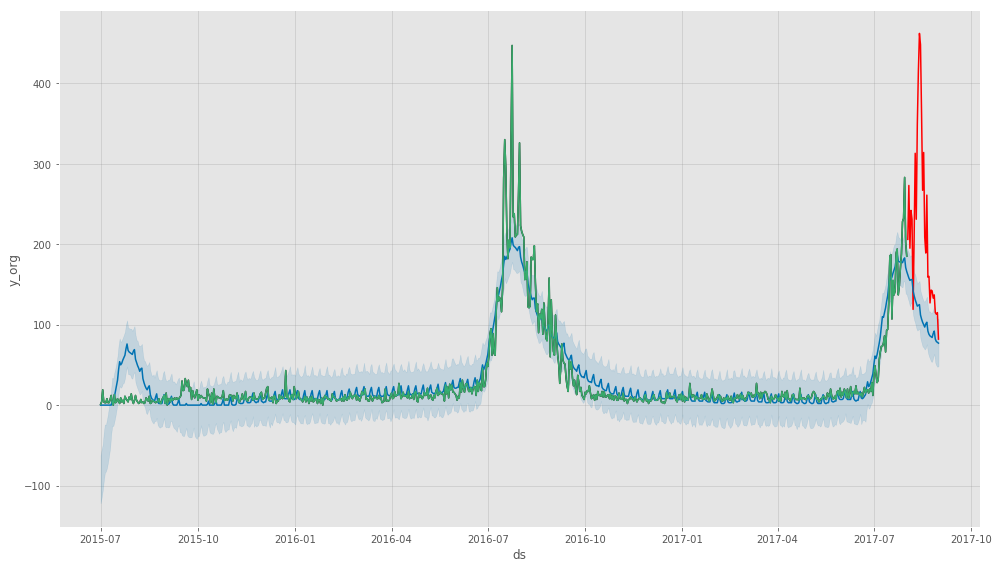

In [258]:
for row in get_df_for_thresh(c[0]).iterrows():
    print('page_index', int(row[1][0]))
    print('v6_val', row[1][-2])
    print('smape_60_to_30', row[1][-1])
    print('val_gain', row[1][1])
    print('smape_30_to_0', row[1][2])
    print('v6t_val', row[1][3])
    print('test_gain', row[1][4])
    print('nans_60_to_30', row[1][5])   
    print('median_pred_60', row[1][7]) 
    print('median_pred_30', row[1][8])    
    load_plot(str(int(row[1][0])))
    load_plot(str(int(row[1][0])), test=True)

In [263]:
test_forecast = pd.read_feather(PROPHET_PATH+VERSION+str(get_df_for_thresh(c[0]).index[0])+'df.f')

In [266]:
VERSION

'v6/'

In [264]:
test_forecast.columns

Index(['ds', 't', 'trend', 'seasonal_lower', 'seasonal_upper', 'trend_lower',
       'trend_upper', 'yhat_lower', 'yhat_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'seasonal',
       'yhat', 'yhat_org', 'y', 'y_org', 'train'],
      dtype='object')

In [265]:
test_forecast[test_forecast.train == 0]

ds         t       trend  seasonal_lower  seasonal_upper  \
703 2017-06-03  1.001425  323.444686     -106.392166     -106.392166   
704 2017-06-04  1.002849  323.799824      -91.143972      -91.143972   
705 2017-06-05  1.004274  324.154962     -112.652729     -112.652729   
706 2017-06-06  1.005698  324.510101     -114.244899     -114.244899   
707 2017-06-07  1.007123  324.865239     -121.132274     -121.132274   
708 2017-06-08  1.008547  325.220377     -124.025240     -124.025240   
709 2017-06-09  1.009972  325.575515     -127.660365     -127.660365   
710 2017-06-10  1.011396  325.930653     -106.554560     -106.554560   
711 2017-06-11  1.012821  326.285791      -87.478910      -87.478910   
712 2017-06-12  1.014245  326.640930     -104.221508     -104.221508   
713 2017-06-13  1.015670  326.996068     -100.102391     -100.102391   
714 2017-06-14  1.017094  327.351206     -100.343213     -100.343213   
715 2017-06-15  1.018519  327.706344      -95.680587      -95.680587   
716 2017-06-16  1.019943  328.061482      -90.893414      -90.893414   
717 2017-06-17  1.021368  328.416620      -60.556456      -60.556456   
718 2017-06-18  1.022792  328.771759      -31.513265      -31.513265   
719 2017-06-19  1.024217  329.126897      -37.637815      -37.637815   
720 2017-06-20  1.025641  329.482035      -22.347995      -22.347995   
721 2017-06-21  1.027066  329.837173      -10.973595      -10.973595   
722 2017-06-22  1.028490  330.192311        5.632203        5.632203   
723 2017-06-23  1.029915  330.547449       22.567488       22.567488   
724 2017-06-24  1.031339  330.902588       65.130129       65.130129   
725 2017-06-25  1.032764  331.257726      106.346957      106.346957   
726 2017-06-26  1.034188  331.612864      112.214241      112.214241   
727 2017-06-27  1.035613  331.968002      139.186241      139.186241   
728 2017-06-28  1.037037  332.323140      161.809166      161.809166   
729 2017-06-29  1.038462  332.678278      189.111481      189.111481   
730 2017-06-30  1.039886  333.033417      216.080189      216.080189   
731 2017-07-01  1.041311  333.388555      267.910748      267.910748   
732 2017-07-02  1.042735  333.743693      317.537433      317.537433   
733 2017-07-03  1.044160  334.098831      330.874727      330.874727   
734 2017-07-04  1.045584  334.453969      364.306551      364.306551   
735 2017-07-05  1.047009  334.809107      392.320613      392.320613   
736 2017-07-06  1.048433  335.164246      423.898865      423.898865   
737 2017-07-07  1.049858  335.519384      453.993687      453.993687   
738 2017-07-08  1.051282  335.874522      507.777472      507.777472   
739 2017-07-09  1.052707  336.229660      558.172463      558.172463   
740 2017-07-10  1.054131  336.584798      571.091437      571.091437   
741 2017-07-11  1.055556  336.939936      602.926093      602.926093   
742 2017-07-12  1.056980  337.295075      628.180445      628.180445   
743 2017-07-13  1.058405  337.650213      655.860262      655.860262   
744 2017-07-14  1.059829  338.005351      680.948197      680.948197   
745 2017-07-15  1.061254  338.360489      728.652327      728.652327   
746 2017-07-16  1.062678  338.715627      771.934974      771.934974   
747 2017-07-17  1.064103  339.070765      776.752463      776.752463   
748 2017-07-18  1.065527  339.425904      799.542657      799.542657   
749 2017-07-19  1.066952  339.781042      814.857644      814.857644   
750 2017-07-20  1.068376  340.136180      831.752592      831.752592   
751 2017-07-21  1.069801  340.491318      845.260459      845.260459   
752 2017-07-22  1.071225  340.846456      880.640254      880.640254   
753 2017-07-23  1.072650  341.201594      910.905756      910.905756   
754 2017-07-24  1.074074  341.556733      902.065300      902.065300   
755 2017-07-25  1.075499  341.911871      910.609493      910.609493   
756 2017-07-26  1.076923  342.267009      911.144189      911.144189   
757 2017-07-27  1.078348  342.622147      912.779736

In [250]:
test_forecast[test_forecast.train == 0].yhat.median()

658.0

In [251]:
get_df_for_thresh(c[0])

page_index    val_gain  smape_30_to_0     v6t_val  test_gain  \
16544        16544  116.069811      45.070908   17.122457  27.948451   
21678        21678  109.603175      47.873016   49.714286  -1.841270   
26201        26201  110.646726      62.643611   54.081253   8.562358   
44555        44555   99.394462      59.839163   76.734311 -16.895148   
45736        45736  102.957356     144.257085  153.965547  -9.708462   
46262        46262  107.125279     111.016290   89.902938  21.113352   
51332        51332  104.700305      64.984479   48.797355  16.187123   
52276        52276  114.027384      69.253261   59.218188  10.035073   
54325        54325   93.465545     104.177858   73.426994  30.750864   
55366        55366   93.657572      55.037666   44.860144  10.177523   
56504        56504  129.393826      69.306855   14.397606  54.909249   
59259        59259  109.527533      91.022082   38.775751  52.246331   
72358        72358  112.602145     148.735220  149.909799  -1.174579   
78171        78171  100.209136      80.672154   84.174944  -3.502790   
79710        79710  106.457431     182.982615  186.351293  -3.368678   
85610        85610  105.451995      74.682502   25.236085  49.446416   
92534        92534   96.216081      75.018852   29.149296  45.869555   
93422        93422  120.507669     141.862496  110.947455  30.915041   
93762        93762  106.762425     143.625807  140.294064   3.331744   
96830        96830   97.209967      19.579295   33.717738 -14.138443   
119529      119529  124.398234      77.971928   16.298918  61.673009   
122358      122358  113.161738      98.265531   33.167125  65.098406   
132771      132771  106.696658      75.569393   19.715692  55.853701   
135605      135605   99.322262      97.906117   59.567143  38.338973   

        nans_60_to_30  nans_30_to_0  median_pred_60  median_pred_30  \
16544               0             0             204             773   
21678               0             0               0               2   
26201               0             1             103            1240   
44555               0             0             618             117   
45736               0             2             251              44   
46262               0             0             161              29   
51332               0             0              37             451   
52276               0             0              58             971   
54325               0             0             104             543   
55366               0             0             268            2298   
56504               0             0             187             845   
59259               0             0             115             702   
72358               0             0             102            1172   
78171               0             0              58               9   
79710               0             2             230              32   
85610               0             0             137             362   
92534               0             1             338            1810   
93422               0             1             177            1825   
93762               0             1             176            1397   
96830               0             0            1355             356   
119529              0             1             319            1146   
122358              0             1             176             914   
132771              0             0              24              78   
135605              0             0              15              66   

           v6_val  smape_60_to_30  
16544   17.831201      133.901013  
21678   77.063492      186.666667  
26201   52.768173      163.414899  
44555   50.550387      149.944849  
45736   51.931677      154.889033  
46262   51.158888      158.284167  
51332   58.630234      163.330539  
52276   57.621414      171.648798  
54325   51.633105      145.098649  
55366   56.039589      149.697161  
56504   19.467319      148.861144  

In [233]:
df2.head()

page_index    val_gain  smape_30_to_0     v6t_val  test_gain  \
0           0   -0.177277      33.460075   33.687425  -0.227350   
1           1  -13.772666      38.381387   79.017942 -40.636555   
2           2 -100.742387      66.482751  118.306120 -51.823369   
3           3  -43.266739      34.090675   47.967008 -13.876332   
4           4  -90.040740      63.728757   99.351753 -35.622996   

   nans_60_to_30  nans_30_to_0  median_pred_60  median_pred_30      v6_val  
0              0             0              24              22   31.961856  
1              0             0              24              18   61.550763  
2              0             0               3               3  162.870370  
3              0             0              15              14   74.371935  
4              0             0              14              12  132.702086

In [231]:
df2['v6_val'] = v6.v6_val

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [235]:
df2.loc[22889]

page_index        22889.000000
val_gain            152.032520
smape_30_to_0         0.000000
v6t_val              53.333333
test_gain           -53.333333
nans_60_to_30        18.000000
nans_30_to_0         15.000000
median_pred_60       18.000000
median_pred_30        0.000000
v6_val               47.967480
Name: 22889, dtype: float64

In [ ]:
df2.val_gain

In [237]:
for row in df2[(df2['val_gain'] > 150)].sort_values(
    by='val_gain',ascending=True).iloc[:0].iterrows():
    print('page_index', row[1][0])
    print('v6_val', row[1][-1])
    print('val_gain', row[1][1])
    print('smape_30_to_0', row[1][2])
    print('v6t_val', row[1][3])
    print('test_gain', row[1][4])
    print('nans_60_to_30', row[1][5])
    load_plot(str(int(row[1][0])))